# Analysis of COVID-19 County Data from The New York Times

*Author: Mark Bauer*  
*Date: April 11, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.1.1
matplotlib.pyplot 3.1.1
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

covid_19_counties_data = pd.read_csv(url)

In [4]:
covid_19_counties_data.head(10)

date       county       state     fips  cases  deaths
0  2020-01-21    Snohomish  Washington  53061.0      1       0
1  2020-01-22    Snohomish  Washington  53061.0      1       0
2  2020-01-23    Snohomish  Washington  53061.0      1       0
3  2020-01-24         Cook    Illinois  17031.0      1       0
4  2020-01-24    Snohomish  Washington  53061.0      1       0
5  2020-01-25       Orange  California   6059.0      1       0
6  2020-01-25         Cook    Illinois  17031.0      1       0
7  2020-01-25    Snohomish  Washington  53061.0      1       0
8  2020-01-26     Maricopa     Arizona   4013.0      1       0
9  2020-01-26  Los Angeles  California   6037.0      1       0

In [5]:
table = covid_19_counties_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="county", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | county        | state        | cases   | deaths   |
|---:|:-----------|:--------------|:-------------|:--------|:---------|
|  0 | 2020-05-05 | New York City | New York     | 176,935 | 13,336   |
|  1 | 2020-05-05 | Cook          | Illinois     | 45,223  | 1,922    |
|  2 | 2020-05-05 | Nassau        | New York     | 37,152  | 2,250    |
|  3 | 2020-05-05 | Suffolk       | New York     | 35,275  | 1,347    |
|  4 | 2020-05-05 | Westchester   | New York     | 30,239  | 1,236    |
|  5 | 2020-05-05 | Los Angeles   | California   | 27,815  | 1,313    |
|  6 | 2020-05-05 | Wayne         | Michigan     | 17,391  | 1,945    |
|  7 | 2020-05-05 | Bergen        | New Jersey   | 16,460  | 1,261    |
|  8 | 2020-05-05 | Philadelphia  | Pennsylvania | 16,410  | 743      |
|  9 | 2020-05-05 | Hudson        | New Jersey   | 16,099  | 870      |


In [6]:
covid_19_counties_data.shape

(118343, 6)

In [7]:
print('New York Times COVID-19 data as of', covid_19_counties_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-05-05


In [8]:
current_date = covid_19_counties_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-05-05


In [10]:
covid_19_counties_data.date = pd.to_datetime(covid_19_counties_data.date, infer_datetime_format=True)

In [11]:
covid_19_counties_data.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths             int64
dtype: object

In [12]:
print(covid_19_counties_data['county'])

0          Snohomish
1          Snohomish
2          Snohomish
3               Cook
4          Snohomish
             ...    
118338      Sublette
118339    Sweetwater
118340         Teton
118341         Uinta
118342      Washakie
Name: county, Length: 118343, dtype: object


In [13]:
covid_19_counties_data['county_name'] = (covid_19_counties_data['county'] + ", " + covid_19_counties_data['state'])

In [14]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0      2020-01-21   Snohomish  Washington  53061.0      1       0   
1      2020-01-22   Snohomish  Washington  53061.0      1       0   
2      2020-01-23   Snohomish  Washington  53061.0      1       0   
3      2020-01-24        Cook    Illinois  17031.0      1       0   
4      2020-01-24   Snohomish  Washington  53061.0      1       0   
...           ...         ...         ...      ...    ...     ...   
118338 2020-05-05    Sublette     Wyoming  56035.0      1       0   
118339 2020-05-05  Sweetwater     Wyoming  56037.0     11       0   
118340 2020-05-05       Teton     Wyoming  56039.0     67       1   
118341 2020-05-05       Uinta     Wyoming  56041.0      6       0   
118342 2020-05-05    Washakie     Wyoming  56043.0      4       0   

                  county_name  
0       Snohomish, Washington  
1       Snohomish, Washington  
2       Snohomish, Washington  
3              Cook, Illinois  
4       Snohomish, Washington  
...                       ...  
118338      Sublette, Wyoming  
118339    Sweetwater, Wyoming  
118340         Teton, Wyoming  
118341         Uinta, Wyoming  
118342      Washakie, Wyoming  

[118343 rows x 7 columns]

In [15]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

date   county           state  fips  cases  deaths  \
418    2020-03-01  Unknown    Rhode Island   NaN      2       0   
450    2020-03-02  Unknown    Rhode Island   NaN      2       0   
485    2020-03-03  Unknown    Rhode Island   NaN      2       0   
522    2020-03-04  Unknown    Rhode Island   NaN      2       0   
569    2020-03-05  Unknown    Rhode Island   NaN      2       0   
...           ...      ...             ...   ...    ...     ...   
117591 2020-05-05  Unknown    Rhode Island   NaN   1414      36   
118015 2020-05-05  Unknown            Utah   NaN      0       3   
118031 2020-05-05  Unknown         Vermont   NaN      4       0   
118035 2020-05-05  Unknown  Virgin Islands   NaN     66       4   
118154 2020-05-05  Unknown        Virginia   NaN      2       0   

                    county_name  
418       Unknown, Rhode Island  
450       Unknown, Rhode Island  
485       Unknown, Rhode Island  
522       Unknown, Rhode Island  
569       Unknown, Rhode Island  
...                         ...  
117591    Unknown, Rhode Island  
118015            Unknown, Utah  
118031         Unknown, Vermont  
118035  Unknown, Virgin Islands  
118154        Unknown, Virginia  

[1259 rows x 7 columns]

In [16]:
print(len(covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']))

1259


In [17]:
covid_19_counties_data = covid_19_counties_data.loc[covid_19_counties_data.county != 'Unknown']

In [18]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

Empty DataFrame
Columns: [date, county, state, fips, cases, deaths, county_name]
Index: []

# Begin Analysis

In [19]:
covid_19_counties_data.dtypes

date           datetime64[ns]
county                 object
state                  object
fips                  float64
cases                   int64
deaths                  int64
county_name            object
dtype: object

In [20]:
epi_curve = covid_19_counties_data.sort_values(by='date')

In [21]:
epi_curve = epi_curve.groupby(by='date')['cases'].sum().reset_index()

In [22]:
epi_curve['NewDate'] = epi_curve.date.dt.strftime("%m-%d")

In [23]:
epi_curve

date    cases NewDate
0   2020-01-21        1   01-21
1   2020-01-22        1   01-22
2   2020-01-23        1   01-23
3   2020-01-24        2   01-24
4   2020-01-25        3   01-25
..         ...      ...     ...
101 2020-05-01  1095113   05-01
102 2020-05-02  1124231   05-02
103 2020-05-03  1149155   05-03
104 2020-05-04  1171203   05-04
105 2020-05-05  1194892   05-05

[106 rows x 3 columns]

In [24]:
epi_curve['daily_cases'] = epi_curve['cases'].diff()

In [25]:
epi_curve.head()

date  cases NewDate  daily_cases
0 2020-01-21      1   01-21          NaN
1 2020-01-22      1   01-22          0.0
2 2020-01-23      1   01-23          0.0
3 2020-01-24      2   01-24          1.0
4 2020-01-25      3   01-25          1.0

In [26]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

0   NaN
Name: daily_cases, dtype: float64

In [27]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()] = epi_curve.cases

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

Series([], Name: daily_cases, dtype: float64)

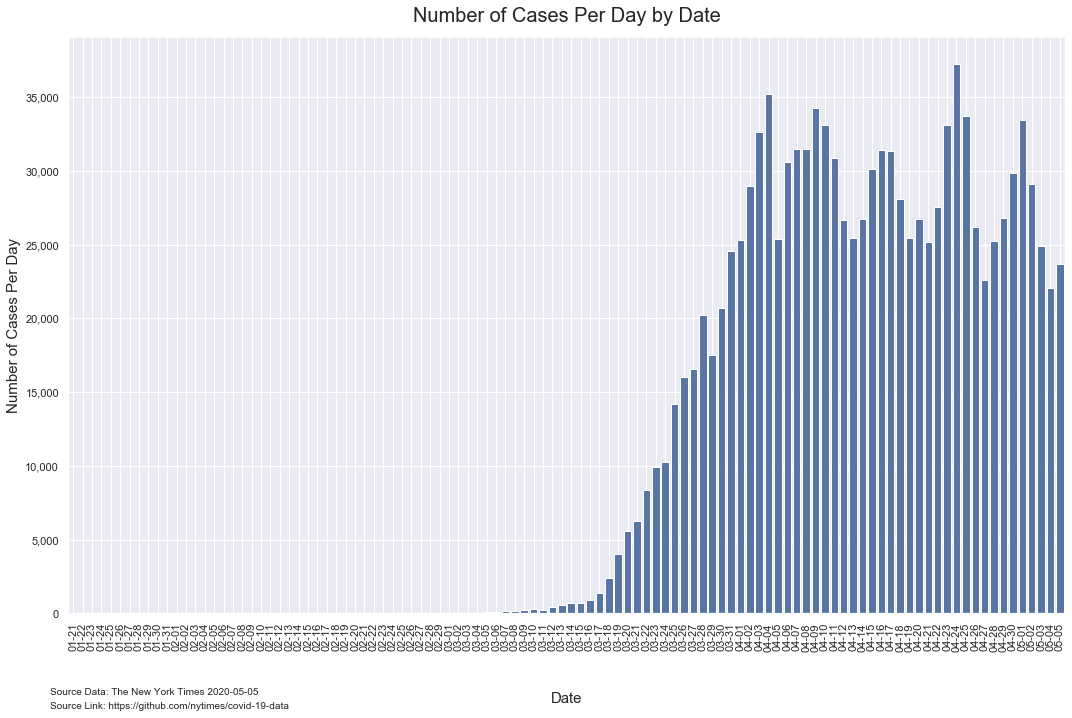

In [29]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

#ax1.legend_.remove()
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

In [30]:
epi_curve['3_day_rolling_average'] = epi_curve.daily_cases.rolling(3).mean()

In [31]:
epi_curve

date    cases NewDate  daily_cases  3_day_rolling_average
0   2020-01-21        1   01-21          1.0                    NaN
1   2020-01-22        1   01-22          0.0                    NaN
2   2020-01-23        1   01-23          0.0               0.333333
3   2020-01-24        2   01-24          1.0               0.333333
4   2020-01-25        3   01-25          1.0               0.666667
..         ...      ...     ...          ...                    ...
101 2020-05-01  1095113   05-01      33463.0           30052.000000
102 2020-05-02  1124231   05-02      29118.0           30811.000000
103 2020-05-03  1149155   05-03      24924.0           29168.333333
104 2020-05-04  1171203   05-04      22048.0           25363.333333
105 2020-05-05  1194892   05-05      23689.0           23553.666667

[106 rows x 5 columns]

In [32]:
epi_curve['3_day_rolling_average'].fillna(0, inplace=True)

In [33]:
epi_curve.head()

date  cases NewDate  daily_cases  3_day_rolling_average
0 2020-01-21      1   01-21          1.0               0.000000
1 2020-01-22      1   01-22          0.0               0.000000
2 2020-01-23      1   01-23          0.0               0.333333
3 2020-01-24      2   01-24          1.0               0.333333
4 2020-01-25      3   01-25          1.0               0.666667

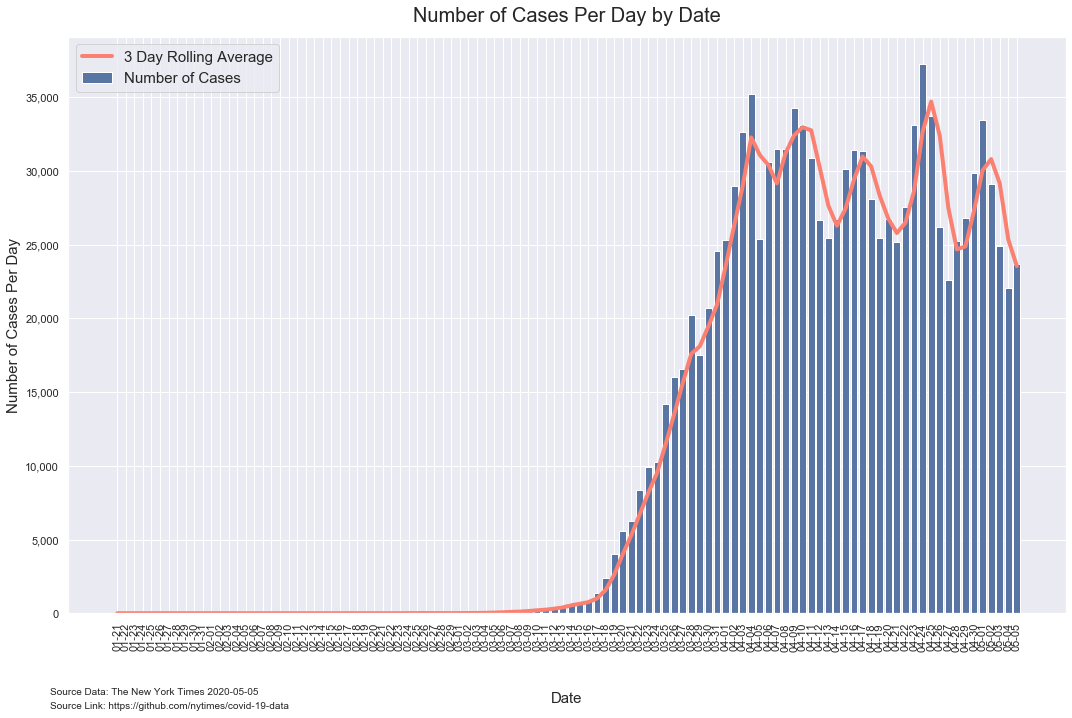

In [34]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve,
            label = 'Number of Cases')

sns.lineplot(x="NewDate", 
            y="3_day_rolling_average",
            color="salmon",
            data=epi_curve, 
            linewidth=4,
            label = '3 Day Rolling Average')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('D'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

leg = ax1.legend(loc='upper left', fontsize=15)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/epi_curve')

In [35]:
drop_duplicates = covid_19_counties_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="county_name", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.county_name)
top_10  = covid_19_counties_data.loc[covid_19_counties_data['county_name'].isin(top10_list)]

In [36]:
top_10

date         county         state     fips   cases  deaths  \
3      2020-01-24           Cook      Illinois  17031.0       1       0   
6      2020-01-25           Cook      Illinois  17031.0       1       0   
9      2020-01-26    Los Angeles    California   6037.0       1       0   
11     2020-01-26           Cook      Illinois  17031.0       1       0   
14     2020-01-27    Los Angeles    California   6037.0       1       0   
...           ...            ...           ...      ...     ...     ...   
117160 2020-05-05         Nassau      New York  36059.0   37152    2250   
117161 2020-05-05  New York City      New York      NaN  176935   13336   
117180 2020-05-05        Suffolk      New York  36103.0   35275    1347   
117188 2020-05-05    Westchester      New York  36119.0   30239    1236   
117569 2020-05-05   Philadelphia  Pennsylvania  42101.0   16410     743   

                       county_name  
3                   Cook, Illinois  
6                   Cook, Illinois  
9          Los Angeles, California  
11                  Cook, Illinois  
14         Los Angeles, California  
...                            ...  
117160            Nassau, New York  
117161     New York City, New York  
117180           Suffolk, New York  
117188       Westchester, New York  
117569  Philadelphia, Pennsylvania  

[689 rows x 7 columns]

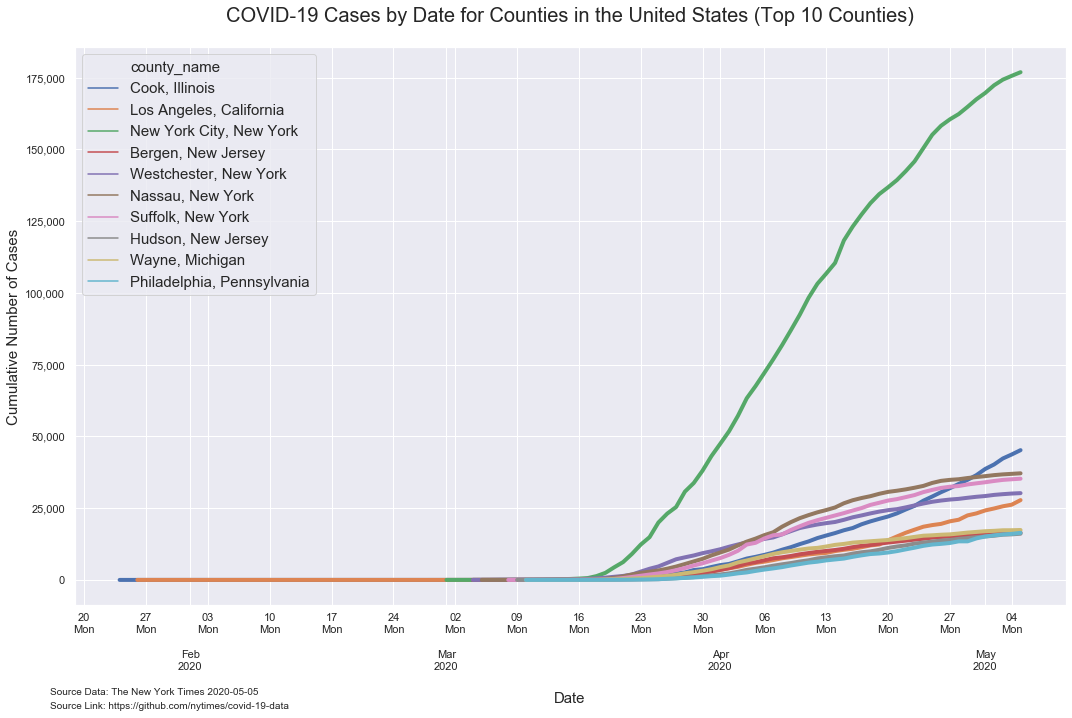

In [37]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10')

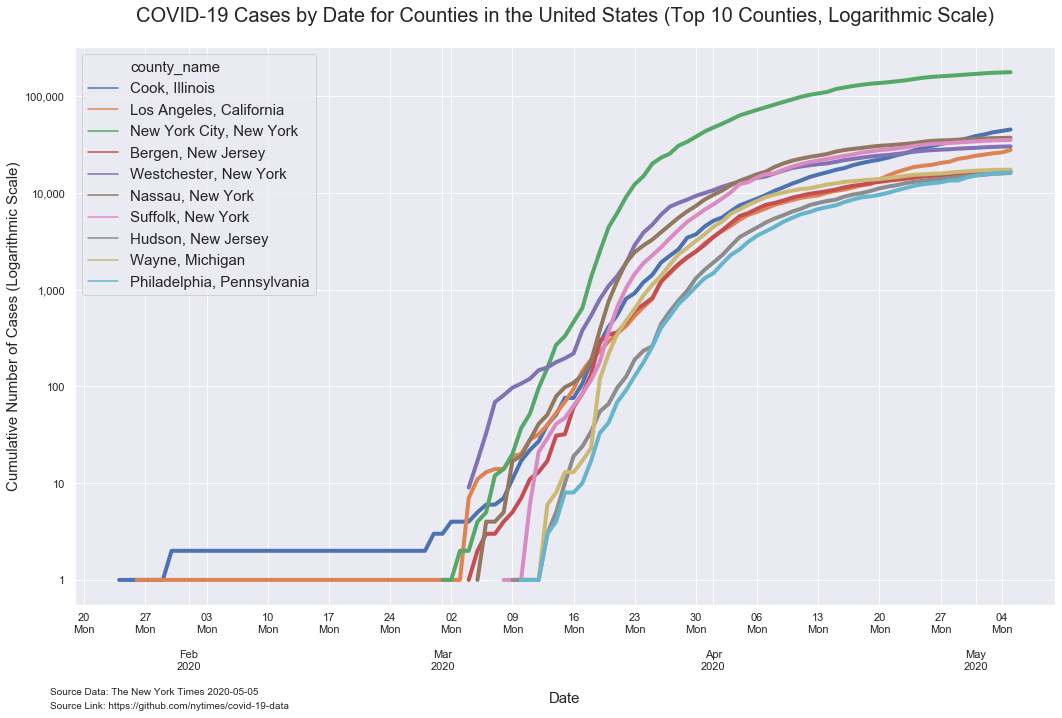

In [38]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10-log')

# Date to 10 Cases

In [39]:
county_ten_cases = top_10.loc[top_10.cases >= 10]

In [40]:
county_ten_cases = county_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="county_name", 
                                                                                      keep = 'first').reset_index(drop=True)

In [41]:
county_ten_cases = county_ten_cases[['date', 'county_name']]
county_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [42]:
county_ten_cases

date_ten_case                 county_name
0    2020-03-05     Los Angeles, California
1    2020-03-05       Westchester, New York
2    2020-03-07     New York City, New York
3    2020-03-09              Cook, Illinois
4    2020-03-09            Nassau, New York
5    2020-03-11          Bergen, New Jersey
6    2020-03-12           Suffolk, New York
7    2020-03-15          Hudson, New Jersey
8    2020-03-15             Wayne, Michigan
9    2020-03-17  Philadelphia, Pennsylvania

In [43]:
county_ten_cases = top_10.merge(county_ten_cases, left_on='county_name', right_on='county_name')

In [44]:
county_ten_cases

date        county         state     fips  cases  deaths  \
0   2020-01-24          Cook      Illinois  17031.0      1       0   
1   2020-01-25          Cook      Illinois  17031.0      1       0   
2   2020-01-26          Cook      Illinois  17031.0      1       0   
3   2020-01-27          Cook      Illinois  17031.0      1       0   
4   2020-01-28          Cook      Illinois  17031.0      1       0   
..         ...           ...           ...      ...    ...     ...   
684 2020-05-01  Philadelphia  Pennsylvania  42101.0  15137     638   
685 2020-05-02  Philadelphia  Pennsylvania  42101.0  15527     705   
686 2020-05-03  Philadelphia  Pennsylvania  42101.0  15854     727   
687 2020-05-04  Philadelphia  Pennsylvania  42101.0  16040     726   
688 2020-05-05  Philadelphia  Pennsylvania  42101.0  16410     743   

                    county_name date_ten_case  
0                Cook, Illinois    2020-03-09  
1                Cook, Illinois    2020-03-09  
2                Cook, Illinois    2020-03-09  
3                Cook, Illinois    2020-03-09  
4                Cook, Illinois    2020-03-09  
..                          ...           ...  
684  Philadelphia, Pennsylvania    2020-03-17  
685  Philadelphia, Pennsylvania    2020-03-17  
686  Philadelphia, Pennsylvania    2020-03-17  
687  Philadelphia, Pennsylvania    2020-03-17  
688  Philadelphia, Pennsylvania    2020-03-17  

[689 rows x 8 columns]

In [45]:
county_ten_cases = county_ten_cases.loc[county_ten_cases.cases >= 10]

In [46]:
county_ten_cases

date        county         state     fips  cases  deaths  \
45  2020-03-09          Cook      Illinois  17031.0     11       0   
46  2020-03-10          Cook      Illinois  17031.0     17       0   
47  2020-03-11          Cook      Illinois  17031.0     22       0   
48  2020-03-12          Cook      Illinois  17031.0     27       0   
49  2020-03-13          Cook      Illinois  17031.0     40       0   
..         ...           ...           ...      ...    ...     ...   
684 2020-05-01  Philadelphia  Pennsylvania  42101.0  15137     638   
685 2020-05-02  Philadelphia  Pennsylvania  42101.0  15527     705   
686 2020-05-03  Philadelphia  Pennsylvania  42101.0  15854     727   
687 2020-05-04  Philadelphia  Pennsylvania  42101.0  16040     726   
688 2020-05-05  Philadelphia  Pennsylvania  42101.0  16410     743   

                    county_name date_ten_case  
45               Cook, Illinois    2020-03-09  
46               Cook, Illinois    2020-03-09  
47               Cook, Illinois    2020-03-09  
48               Cook, Illinois    2020-03-09  
49               Cook, Illinois    2020-03-09  
..                          ...           ...  
684  Philadelphia, Pennsylvania    2020-03-17  
685  Philadelphia, Pennsylvania    2020-03-17  
686  Philadelphia, Pennsylvania    2020-03-17  
687  Philadelphia, Pennsylvania    2020-03-17  
688  Philadelphia, Pennsylvania    2020-03-17  

[565 rows x 8 columns]

In [47]:
county_ten_cases['days_since_ten_case'] = (county_ten_cases['date'] - 
                                      county_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
county_ten_cases

date        county         state     fips  cases  deaths  \
45  2020-03-09          Cook      Illinois  17031.0     11       0   
46  2020-03-10          Cook      Illinois  17031.0     17       0   
47  2020-03-11          Cook      Illinois  17031.0     22       0   
48  2020-03-12          Cook      Illinois  17031.0     27       0   
49  2020-03-13          Cook      Illinois  17031.0     40       0   
..         ...           ...           ...      ...    ...     ...   
684 2020-05-01  Philadelphia  Pennsylvania  42101.0  15137     638   
685 2020-05-02  Philadelphia  Pennsylvania  42101.0  15527     705   
686 2020-05-03  Philadelphia  Pennsylvania  42101.0  15854     727   
687 2020-05-04  Philadelphia  Pennsylvania  42101.0  16040     726   
688 2020-05-05  Philadelphia  Pennsylvania  42101.0  16410     743   

                    county_name date_ten_case  days_since_ten_case  
45               Cook, Illinois    2020-03-09                    0  
46               Cook, Illinois    2020-03-09                    1  
47               Cook, Illinois    2020-03-09                    2  
48               Cook, Illinois    2020-03-09                    3  
49               Cook, Illinois    2020-03-09                    4  
..                          ...           ...                  ...  
684  Philadelphia, Pennsylvania    2020-03-17                   45  
685  Philadelphia, Pennsylvania    2020-03-17                   46  
686  Philadelphia, Pennsylvania    2020-03-17                   47  
687  Philadelphia, Pennsylvania    2020-03-17                   48  
688  Philadelphia, Pennsylvania    2020-03-17                   49  

[565 rows x 9 columns]

# Daily Number of Cases Since 10th Case

In [49]:
county_ten_cases['daily_cases'] = (county_ten_cases.cases -
                                county_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
county_ten_cases[:50]

date county     state     fips  cases  deaths     county_name  \
45 2020-03-09   Cook  Illinois  17031.0     11       0  Cook, Illinois   
46 2020-03-10   Cook  Illinois  17031.0     17       0  Cook, Illinois   
47 2020-03-11   Cook  Illinois  17031.0     22       0  Cook, Illinois   
48 2020-03-12   Cook  Illinois  17031.0     27       0  Cook, Illinois   
49 2020-03-13   Cook  Illinois  17031.0     40       0  Cook, Illinois   
50 2020-03-14   Cook  Illinois  17031.0     51       0  Cook, Illinois   
51 2020-03-15   Cook  Illinois  17031.0     76       0  Cook, Illinois   
52 2020-03-16   Cook  Illinois  17031.0     76       0  Cook, Illinois   
53 2020-03-17   Cook  Illinois  17031.0    107       1  Cook, Illinois   
54 2020-03-18   Cook  Illinois  17031.0    179       1  Cook, Illinois   
55 2020-03-19   Cook  Illinois  17031.0    279       2  Cook, Illinois   
56 2020-03-20   Cook  Illinois  17031.0    412       3  Cook, Illinois   
57 2020-03-21   Cook  Illinois  17031.0    548       4  Cook, Illinois   
58 2020-03-22   Cook  Illinois  17031.0    805       6  Cook, Illinois   
59 2020-03-23   Cook  Illinois  17031.0    922       9  Cook, Illinois   
60 2020-03-24   Cook  Illinois  17031.0   1194      12  Cook, Illinois   
61 2020-03-25   Cook  Illinois  17031.0   1418      13  Cook, Illinois   
62 2020-03-26   Cook  Illinois  17031.0   1904      18  Cook, Illinois   
63 2020-03-27   Cook  Illinois  17031.0   2239      20  Cook, Illinois   
64 2020-03-28   Cook  Illinois  17031.0   2613      28  Cook, Illinois   
65 2020-03-29   Cook  Illinois  17031.0   3445      40  Cook, Illinois   
66 2020-03-30   Cook  Illinois  17031.0   3727      44  Cook, Illinois   
67 2020-03-31   Cook  Illinois  17031.0   4496      61  Cook, Illinois   
68 2020-04-01   Cook  Illinois  17031.0   5152      95  Cook, Illinois   
69 2020-04-02   Cook  Illinois  17031.0   5575     107  Cook, Illinois   
70 2020-04-03   Cook  Illinois  17031.0   6473     141  Cook, Illinois   
71 2020-04-04   Cook  Illinois  17031.0   7439     167  Cook, Illinois   
72 2020-04-05   Cook  Illinois  17031.0   8043     186  Cook, Illinois   
73 2020-04-06   Cook  Illinois  17031.0   8728     209  Cook, Illinois   
74 2020-04-07   Cook  Illinois  17031.0   9509     249  Cook, Illinois   
75 2020-04-08   Cook  Illinois  17031.0  10520     312  Cook, Illinois   
76 2020-04-09   Cook  Illinois  17031.0  11415     351  Cook, Illinois   
77 2020-04-10   Cook  Illinois  17031.0  12472     398  Cook, Illinois   
78 2020-04-11   Cook  Illinois  17031.0  13417     453  Cook, Illinois   
79 2020-04-12   Cook  Illinois  17031.0  14585     485  Cook, Illinois   
80 2020-04-13   Cook  Illinois  17031.0  15474     543  Cook, Illinois   
81 2020-04-14   Cook  Illinois  17031.0  16323     577  Cook, Illinois   
82 2020-04-15   Cook  Illinois  17031.0  17306     630  Cook, Illinois   
83 2020-04-16   Cook  Illinois  17031.0  18087     722  Cook, Illinois   
84 2020-04-17   Cook  Illinois  17031.0  19391     760  Cook, Illinois   
85 2020-04-18   Cook  Illinois  17031.0  20395     860  Cook, Illinois   
86 2020-04-19   Cook  Illinois  17031.0  21272     877  Cook, Illinois   
87 2020-04-20   Cook  Illinois  17031.0  22101     915  Cook, Illinois   
88 2020-04-21   Cook  Illinois  17031.0  23181    1002  Cook, Illinois   
89 2020-04-22   Cook  Illinois  17031.0  24546    1072  Cook, Illinois   
90 2020-04-23   Cook  Illinois  17031.0  25811    1142  Cook, Illinois   
91 2020-04-24   Cook  Illinois  17031.0  27616    1220  Cook, Illinois   
92 2020-04-25   Cook  Illinois  17031.0  29058    1267  Cook, Illinois   
93 2020-04-26   Cook  Illinois  17031.0  30574    1313  Cook, Illinois   
94 2020-04-27   Cook  Illinois  17031.0  31953    1347  Cook, Illinois   

   date_ten_case  days_since_ten_case  daily_cases  
45    2020-03-09                    0          NaN  
46    2020-03-09                    1          6.0  
47    2020-03-09                    2          5.0  
48    2020-03-09      

In [51]:
county_ten_cases.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'county_name',
       'date_ten_case', 'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [52]:
county_ten_cases = county_ten_cases[['date', 'county', 'county_name', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [53]:
county_ten_cases[250:300]

date       county            county_name  cases  daily_cases  \
348 2020-03-19  Westchester  Westchester, New York    797        260.0   
349 2020-03-20  Westchester  Westchester, New York   1091        294.0   
350 2020-03-21  Westchester  Westchester, New York   1387        296.0   
351 2020-03-22  Westchester  Westchester, New York   1873        486.0   
352 2020-03-23  Westchester  Westchester, New York   2894       1021.0   
353 2020-03-24  Westchester  Westchester, New York   3891        997.0   
354 2020-03-25  Westchester  Westchester, New York   4691        800.0   
355 2020-03-26  Westchester  Westchester, New York   5944       1253.0   
356 2020-03-27  Westchester  Westchester, New York   7187       1243.0   
357 2020-03-28  Westchester  Westchester, New York   7875        688.0   
358 2020-03-29  Westchester  Westchester, New York   8519        644.0   
359 2020-03-30  Westchester  Westchester, New York   9326        807.0   
360 2020-03-31  Westchester  Westchester, New York   9967        641.0   
361 2020-04-01  Westchester  Westchester, New York  10683        716.0   
362 2020-04-02  Westchester  Westchester, New York  11566        883.0   
363 2020-04-03  Westchester  Westchester, New York  12350        784.0   
364 2020-04-04  Westchester  Westchester, New York  13080        730.0   
365 2020-04-05  Westchester  Westchester, New York  13722        642.0   
366 2020-04-06  Westchester  Westchester, New York  14293        571.0   
367 2020-04-07  Westchester  Westchester, New York  14804        511.0   
368 2020-04-08  Westchester  Westchester, New York  15887       1083.0   
369 2020-04-09  Westchester  Westchester, New York  17004       1117.0   
370 2020-04-10  Westchester  Westchester, New York  18077       1073.0   
371 2020-04-11  Westchester  Westchester, New York  18729        652.0   
372 2020-04-12  Westchester  Westchester, New York  19313        584.0   
373 2020-04-13  Westchester  Westchester, New York  19785        472.0   
374 2020-04-14  Westchester  Westchester, New York  20191        406.0   
375 2020-04-15  Westchester  Westchester, New York  20947        756.0   
376 2020-04-16  Westchester  Westchester, New York  21828        881.0   
377 2020-04-17  Westchester  Westchester, New York  22476        648.0   
378 2020-04-18  Westchester  Westchester, New York  23179        703.0   
379 2020-04-19  Westchester  Westchester, New York  23803        624.0   
380 2020-04-20  Westchester  Westchester, New York  24306        503.0   
381 2020-04-21  Westchester  Westchester, New York  24655        349.0   
382 2020-04-22  Westchester  Westchester, New York  25275        620.0   
383 2020-04-23  Westchester  Westchester, New York  25959        684.0   
384 2020-04-24  Westchester  Westchester, New York  26632        673.0   
385 2020-04-25  Westchester  Westchester, New York  27230        598.0   
386 2020-04-26  Westchester  Westchester, New York  27664        434.0   
387 2020-04-27  Westchester  Westchester, New York  28007        343.0   
388 2020-04-28  Westchester  Westchester, New York  28245        238.0   
389 2020-04-29  Westchester  Westchester, New York  28625        380.0   
390 2020-04-30  Westchester  Westchester, New York  28969        344.0   
391 2020-05-01  Westchester  Westchester, New York  29231        262.0   
392 2020-05-02  Westchester  Westchester, New York  29626        395.0   
393 2020-05-03  Westchester  Westchester, New York  29884        258.0   
394 2020-05-04  Westchester  Westchester, New York  30097        213.0   
395 2020-05-05  Westchester  Westchester, New York  30239        142.0   
400 2020-03-09       Nassau       Nassau, New York     17     -30222.0   
401 2020-03-10       Nassau       Nassau, New York     19          2.0   

     deaths date_ten_case  days_since_ten_case  
348       0    2020-03-05                   14  
349       0    2020-03-05                   15  
350       0    2020-03-05                   16  
351       0    2020-03-05              

In [54]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases < 0] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases.isnull()] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
county_ten_cases[:50]

date county     county_name  cases  daily_cases  deaths  \
45 2020-03-09   Cook  Cook, Illinois     11          1.0       0   
46 2020-03-10   Cook  Cook, Illinois     17          6.0       0   
47 2020-03-11   Cook  Cook, Illinois     22          5.0       0   
48 2020-03-12   Cook  Cook, Illinois     27          5.0       0   
49 2020-03-13   Cook  Cook, Illinois     40         13.0       0   
50 2020-03-14   Cook  Cook, Illinois     51         11.0       0   
51 2020-03-15   Cook  Cook, Illinois     76         25.0       0   
52 2020-03-16   Cook  Cook, Illinois     76          0.0       0   
53 2020-03-17   Cook  Cook, Illinois    107         31.0       1   
54 2020-03-18   Cook  Cook, Illinois    179         72.0       1   
55 2020-03-19   Cook  Cook, Illinois    279        100.0       2   
56 2020-03-20   Cook  Cook, Illinois    412        133.0       3   
57 2020-03-21   Cook  Cook, Illinois    548        136.0       4   
58 2020-03-22   Cook  Cook, Illinois    805        257.0       6   
59 2020-03-23   Cook  Cook, Illinois    922        117.0       9   
60 2020-03-24   Cook  Cook, Illinois   1194        272.0      12   
61 2020-03-25   Cook  Cook, Illinois   1418        224.0      13   
62 2020-03-26   Cook  Cook, Illinois   1904        486.0      18   
63 2020-03-27   Cook  Cook, Illinois   2239        335.0      20   
64 2020-03-28   Cook  Cook, Illinois   2613        374.0      28   
65 2020-03-29   Cook  Cook, Illinois   3445        832.0      40   
66 2020-03-30   Cook  Cook, Illinois   3727        282.0      44   
67 2020-03-31   Cook  Cook, Illinois   4496        769.0      61   
68 2020-04-01   Cook  Cook, Illinois   5152        656.0      95   
69 2020-04-02   Cook  Cook, Illinois   5575        423.0     107   
70 2020-04-03   Cook  Cook, Illinois   6473        898.0     141   
71 2020-04-04   Cook  Cook, Illinois   7439        966.0     167   
72 2020-04-05   Cook  Cook, Illinois   8043        604.0     186   
73 2020-04-06   Cook  Cook, Illinois   8728        685.0     209   
74 2020-04-07   Cook  Cook, Illinois   9509        781.0     249   
75 2020-04-08   Cook  Cook, Illinois  10520       1011.0     312   
76 2020-04-09   Cook  Cook, Illinois  11415        895.0     351   
77 2020-04-10   Cook  Cook, Illinois  12472       1057.0     398   
78 2020-04-11   Cook  Cook, Illinois  13417        945.0     453   
79 2020-04-12   Cook  Cook, Illinois  14585       1168.0     485   
80 2020-04-13   Cook  Cook, Illinois  15474        889.0     543   
81 2020-04-14   Cook  Cook, Illinois  16323        849.0     577   
82 2020-04-15   Cook  Cook, Illinois  17306        983.0     630   
83 2020-04-16   Cook  Cook, Illinois  18087        781.0     722   
84 2020-04-17   Cook  Cook, Illinois  19391       1304.0     760   
85 2020-04-18   Cook  Cook, Illinois  20395       1004.0     860   
86 2020-04-19   Cook  Cook, Illinois  21272        877.0     877   
87 2020-04-20   Cook  Cook, Illinois  22101        829.0     915   
88 2020-04-21   Cook  Cook, Illinois  23181       1080.0    1002   
89 2020-04-22   Cook  Cook, Illinois  24546       1365.0    1072   
90 2020-04-23   Cook  Cook, Illinois  25811       1265.0    1142   
91 2020-04-24   Cook  Cook, Illinois  27616       1805.0    1220   
92 2020-04-25   Cook  Cook, Illinois  29058       1442.0    1267   
93 2020-04-26   Cook  Cook, Illinois  30574       1516.0    1313   
94 2020-04-27   Cook  Cook, Illinois  31953       1379.0    1347   

   date_ten_case  days_since_ten_case  
45    2020-03-09                    0  
46    2020-03-09                    1  
47    2020-03-09                    2  
48    2020-03-09                    3  
49    2020-03-09                    4  
50    2020-03-09                    5  
51    2020-03-09                    6  
52    2020-03-09                    7  
53    2020-03-09                    8  
54    2020-03-09                    9  
55    2020-03-09                   10  
56    2020-03-09                   11  
57    2020-03-09    

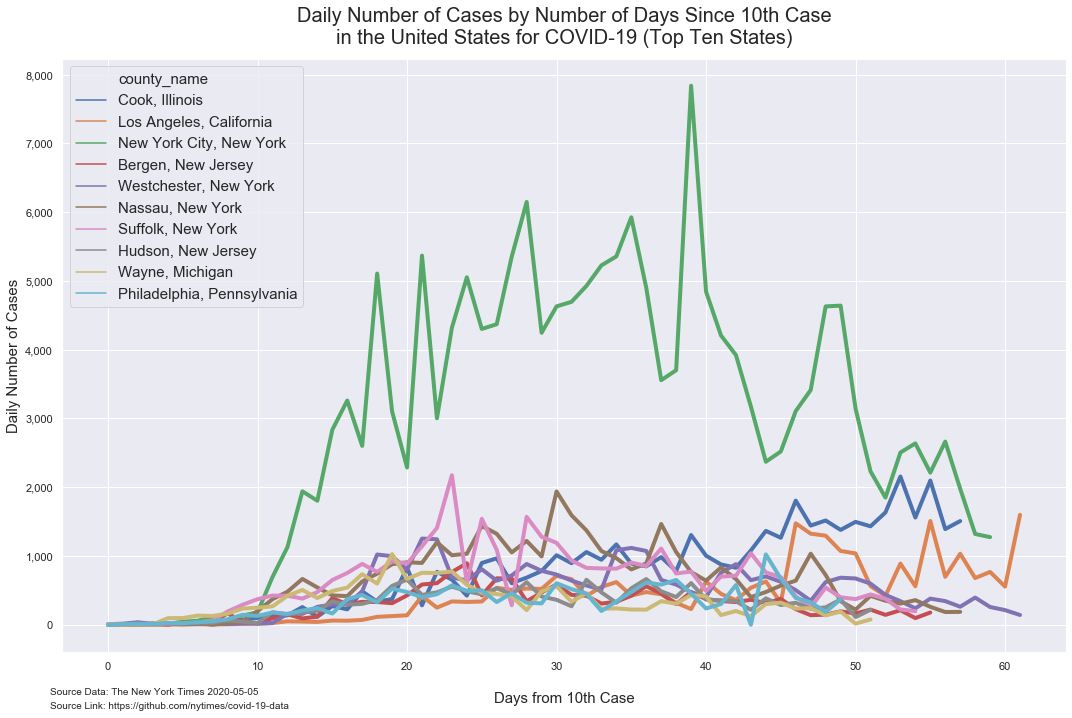

In [57]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily')

In [58]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
145    0.0
523    0.0
581    0.0
639    0.0
682    0.0
Name: daily_cases, dtype: float64

In [59]:
temp_fill_zeros = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[temp_fill_zeros.daily_cases == 0] = 1

temp_fill_zeros

date       county            county_name  cases  daily_cases  \
277 2020-03-11       Bergen     Bergen, New Jersey     11          1.0   
278 2020-03-12       Bergen     Bergen, New Jersey     13          2.0   
279 2020-03-13       Bergen     Bergen, New Jersey     17          4.0   
280 2020-03-14       Bergen     Bergen, New Jersey     31         14.0   
281 2020-03-15       Bergen     Bergen, New Jersey     32          1.0   
..         ...          ...                    ...    ...          ...   
391 2020-05-01  Westchester  Westchester, New York  29231        262.0   
392 2020-05-02  Westchester  Westchester, New York  29626        395.0   
393 2020-05-03  Westchester  Westchester, New York  29884        258.0   
394 2020-05-04  Westchester  Westchester, New York  30097        213.0   
395 2020-05-05  Westchester  Westchester, New York  30239        142.0   

     deaths date_ten_case  days_since_ten_case  
277       1    2020-03-11                    0  
278       1    2020-03-11                    1  
279       1    2020-03-11                    2  
280       1    2020-03-11                    3  
281       1    2020-03-11                    4  
..      ...           ...                  ...  
391    1165    2020-03-05                   57  
392    1183    2020-03-05                   58  
393    1203    2020-03-05                   59  
394    1220    2020-03-05                   60  
395    1236    2020-03-05                   61  

[565 rows x 8 columns]

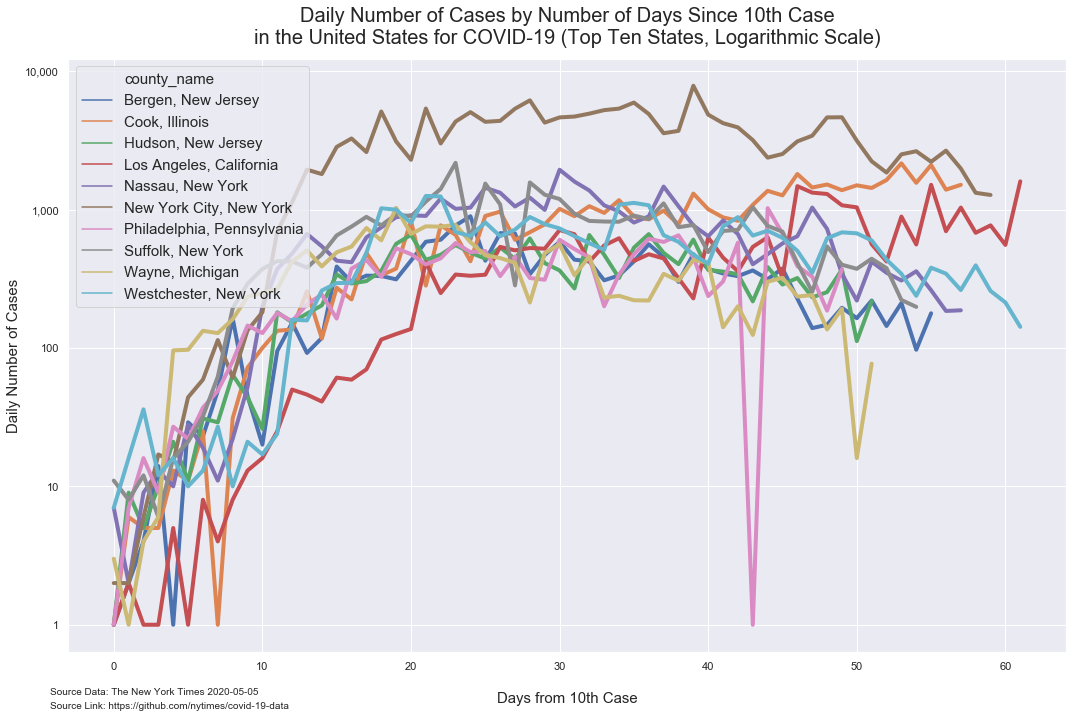

In [60]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily-log')

In [61]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
145    0.0
523    0.0
581    0.0
639    0.0
682    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [62]:
county_ten_cases_weekly = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                    ascending=[True, True, True])

In [63]:
county_ten_cases_weekly[0:30]

date  county         county_name  cases  daily_cases  deaths  \
277 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
282 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
283 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
284 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
285 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
286 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
287 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
288 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
289 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
290 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
291 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
292 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
293 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
294 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
295 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
296 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
297 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
298 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
299 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
300 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
301 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
302 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
303 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
304 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
305 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
306 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   

    date_ten_case  days_since_ten_case  
277    2020-03-11                    0  
278    2020-03-11                    1  
279    2020-03-11                    2  
280    2020-03-11                    3  
281    2020-03-11                    4  
282    2020-03-11                    5  
283    2020-03-11                    6  
284    2020-03-11                    7  
285    2020-03-11                    8  
286    2020-03-11                    9  
287    2020-03-11                   10  
288    2020-03-11                   11  
289    2020-03-11                   12  
290    2020-03-11                   13  
291    2020-03-11                   14  
292    2020-03-11                   15  
293    2020-03-11                   16  
294    2020-03-11                   17  
295    2020-03-11                   18  
296    2020-03-11                   19  
297    2020-03-11                   20  
298    2020-03-11                   21  
299    2020-03-11                   22  
300    2020-03-11                   23  
301    2020-03-11                   24  
302    2020-03-11                   25  
303    2020-03-11                   26  
304    2020-03-11                   27  
305    2020-03-11                   28  
306    2020-03-11                   29

In [64]:
county_ten_cases_weekly = county_ten_cases_weekly.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [65]:
county_ten_cases_weekly

days_since_ten_case  daily_cases
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     4.400000
                      2020-03-22                   11    60.714286
                      2020-03-29                   18   244.571429
                      2020-04-05                   25   574.000000
                      2020-04-12                   32   513.857143
...                                               ...          ...
Westchester, New York 2020-04-12                   38   798.714286
                      2020-04-19                   45   641.428571
                      2020-04-26                   52   551.571429
                      2020-05-03                   59   317.142857
                      2020-05-10                   61   177.500000

[92 rows x 2 columns]

In [66]:
county_ten_cases_weekly.reset_index(inplace=True)
county_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [67]:
county_ten_cases_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
87  Westchester, New York 2020-04-12                   38   
88  Westchester, New York 2020-04-19                   45   
89  Westchester, New York 2020-04-26                   52   
90  Westchester, New York 2020-05-03                   59   
91  Westchester, New York 2020-05-10                   61   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
87                798.714286  
88                641.428571  
89                551.571429  
90                317.142857  
91                177.500000  

[92 rows x 4 columns]

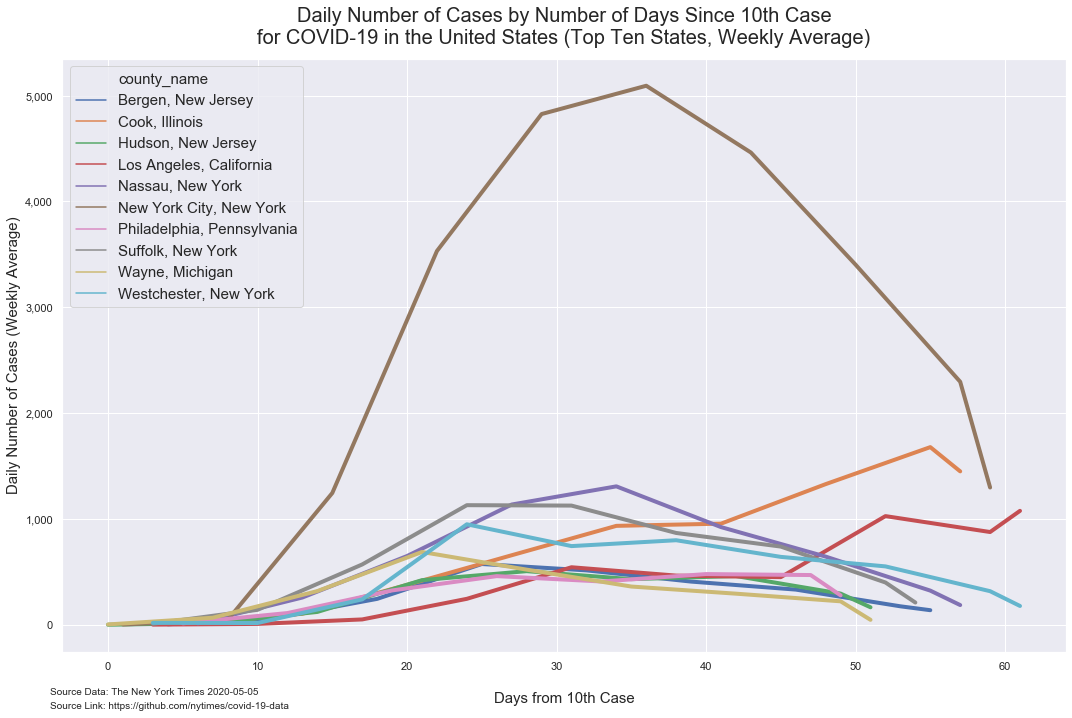

In [68]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly')

In [69]:
county_ten_cases_weekly.sort_values(by='daily_cases_week_average')

county_name       date  days_since_ten_case  \
18       Hudson, New Jersey 2020-03-15                    0   
27  Los Angeles, California 2020-03-08                    3   
46  New York City, New York 2020-03-08                    1   
73          Wayne, Michigan 2020-03-15                    0   
0        Bergen, New Jersey 2020-03-15                    4   
..                      ...        ...                  ...   
53  New York City, New York 2020-04-26                   50   
49  New York City, New York 2020-03-29                   22   
52  New York City, New York 2020-04-19                   43   
50  New York City, New York 2020-04-05                   29   
51  New York City, New York 2020-04-12                   36   

    daily_cases_week_average  
18                  0.000000  
27                  1.000000  
46                  2.000000  
73                  3.000000  
0                   4.400000  
..                       ...  
53               3403.142857  
49               3531.857143  
52               4462.571429  
50               4826.285714  
51               5093.714286  

[92 rows x 4 columns]

In [70]:
temp_fill_zeros = county_ten_cases_weekly.sort_values(by=['county_name', 'date','daily_cases_week_average'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases_week_average'].loc[temp_fill_zeros.daily_cases_week_average == 0] = 1

temp_fill_zeros

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
87  Westchester, New York 2020-04-12                   38   
88  Westchester, New York 2020-04-19                   45   
89  Westchester, New York 2020-04-26                   52   
90  Westchester, New York 2020-05-03                   59   
91  Westchester, New York 2020-05-10                   61   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
87                798.714286  
88                641.428571  
89                551.571429  
90                317.142857  
91                177.500000  

[92 rows x 4 columns]

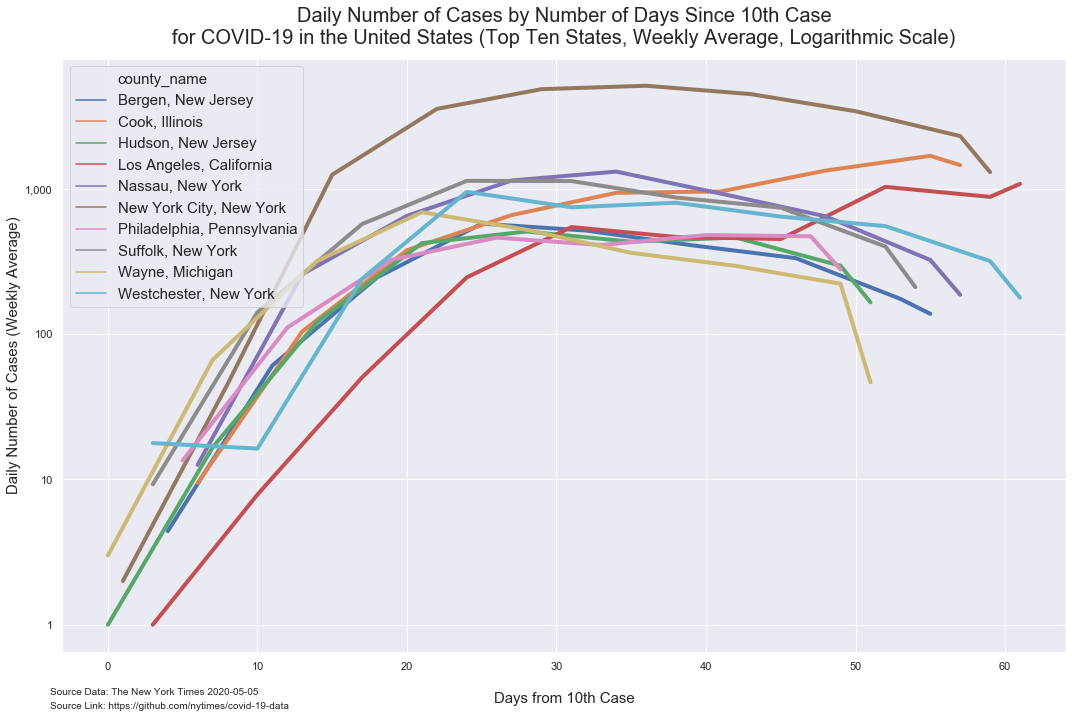

In [71]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [72]:
growth_rate = county_ten_cases.sort_values(by=['county_name', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [73]:
growth_rate.head()

date  county         county_name  cases  daily_cases  deaths  \
277 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   

    date_ten_case  days_since_ten_case  
277    2020-03-11                    0  
278    2020-03-11                    1  
279    2020-03-11                    2  
280    2020-03-11                    3  
281    2020-03-11                    4

In [74]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [75]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
277 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
282 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
283 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
284 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
285 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
286 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
287 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
288 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
289 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
290 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
291 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
292 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
293 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
294 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
295 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
296 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
297 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
298 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
299 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
300 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
301 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
302 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
303 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
304 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
305 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
306 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
307 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
308 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
309 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
310 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
311 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
312 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
313 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
314 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
315 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
316 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
317 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
318 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
319 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
320 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
321 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
322 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
323 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
324 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
325 2020-04-28  Bergen  Bergen, New Jersey  15251        147.0    1002   
326 2020-04-29  Bergen  Bergen, New Jersey  15446        195.0    1057   

    date_ten_case  days_since_ten_case  growth_rate  
277    2020-03-11                    0          NaN  
278    2020-03-11                    1     2.000000  
279    2020-03-11                    2     2.000000  
280    2020-03-11  

In [76]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [77]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [78]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
282 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
283 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
284 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
285 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
286 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
287 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
288 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
289 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
290 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
291 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
292 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
293 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
294 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
295 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
296 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
297 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
298 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
299 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
300 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
301 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
302 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
303 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
304 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
305 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
306 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
307 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
308 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
309 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
310 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
311 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
312 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
313 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
314 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
315 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
316 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
317 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
318 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
319 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
320 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
321 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
322 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
323 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
324 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
325 2020-04-28  Bergen  Bergen, New Jersey  15251        147.0    1002   
326 2020-04-29  Bergen  Bergen, New Jersey  15446        195.0    1057   
327 2020-04-30  Bergen  Bergen, New Jersey  15610        164.0    1136   

    date_ten_case  days_since_ten_case  growth_rate  
278    2020-03-11                    1     2.000000  
279    2020-03-11                    2     2.000000  
280    2020-03-11                    3     3.500000  
281    2020-03-11  

In [79]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [80]:
growth_rate.isna().sum()

date                   0
county                 0
county_name            0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [81]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
282 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
283 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
284 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
285 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
286 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
287 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
288 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
289 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
290 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
291 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
292 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
293 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
294 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
295 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
296 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
297 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
298 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
299 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
300 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
301 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
302 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
303 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
304 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
305 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
306 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
307 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
308 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
309 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
310 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
311 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
312 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
313 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
314 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
315 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
316 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
317 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
318 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
319 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
320 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
321 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
322 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
323 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
324 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
325 2020-04-28  Bergen  Bergen, New Jersey  15251        147.0    1002   
326 2020-04-29  Bergen  Bergen, New Jersey  15446        195.0    1057   
327 2020-04-30  Bergen  Bergen, New Jersey  15610        164.0    1136   

    date_ten_case  days_since_ten_case  growth_rate  
278    2020-03-11                    1     2.000000  
279    2020-03-11                    2     2.000000  
280    2020-03-11                    3     3.500000  
281    2020-03-11  

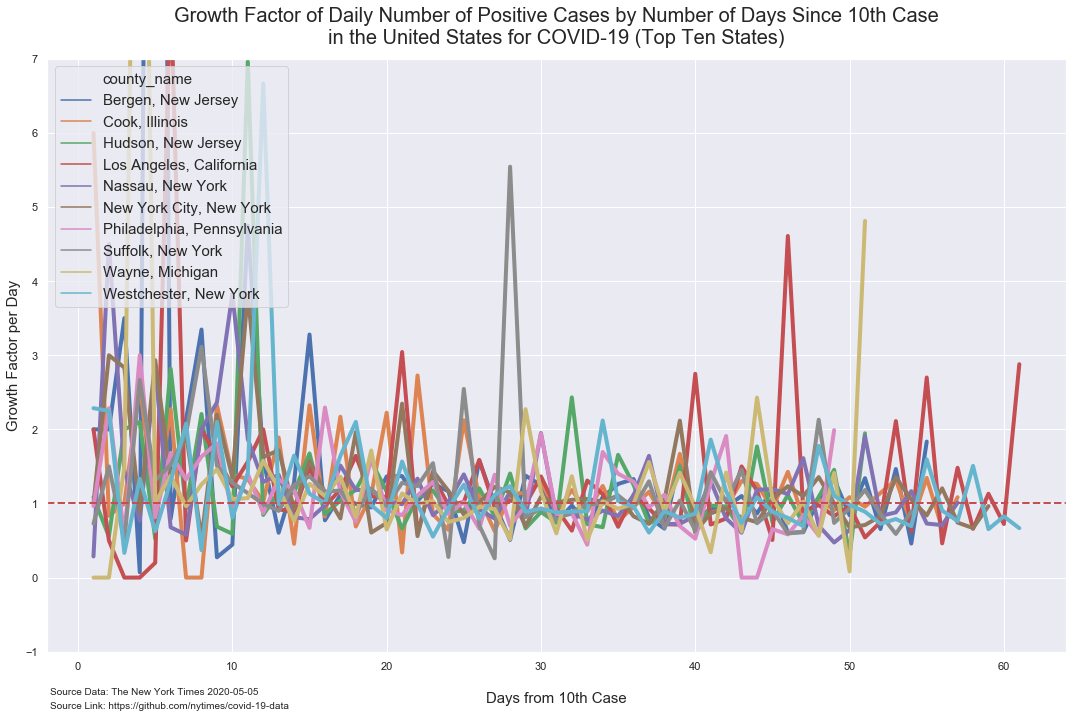

In [82]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="county_name", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 7)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [83]:
growth_rate_weekly = growth_rate.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [84]:
growth_rate_weekly

days_since_ten_case  growth_rate
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     1.892857
                      2020-03-22                   11     5.819902
                      2020-03-29                   18     1.378264
                      2020-04-05                   25     1.089289
                      2020-04-12                   32     1.060000
...                                               ...          ...
Westchester, New York 2020-04-12                   38     1.057008
                      2020-04-19                   45     1.057690
                      2020-04-26                   52     0.996841
                      2020-05-03                   59     0.986933
                      2020-05-10                   61     0.746124

[90 rows x 2 columns]

In [85]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [86]:
growth_rate_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
85  Westchester, New York 2020-04-12                   38   
86  Westchester, New York 2020-04-19                   45   
87  Westchester, New York 2020-04-26                   52   
88  Westchester, New York 2020-05-03                   59   
89  Westchester, New York 2020-05-10                   61   

    growth_rate_weekly_average  
0                     1.892857  
1                     5.819902  
2                     1.378264  
3                     1.089289  
4                     1.060000  
..                         ...  
85                    1.057008  
86                    1.057690  
87                    0.996841  
88                    0.986933  
89                    0.746124  

[90 rows x 4 columns]

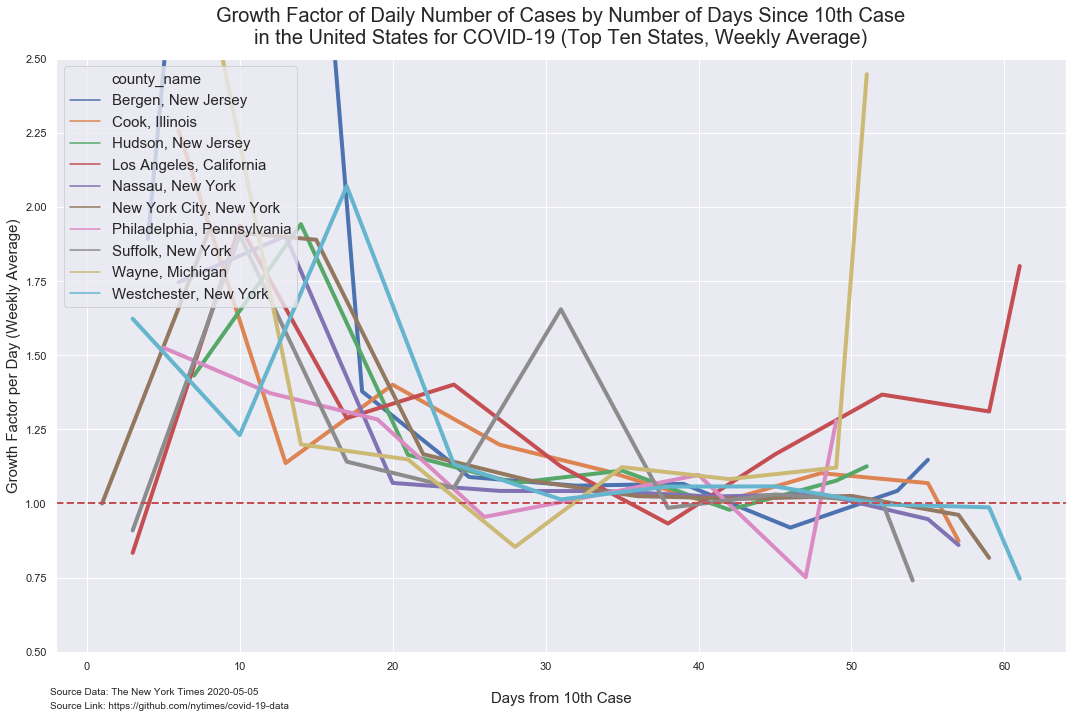

In [87]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="county_name", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2.5)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

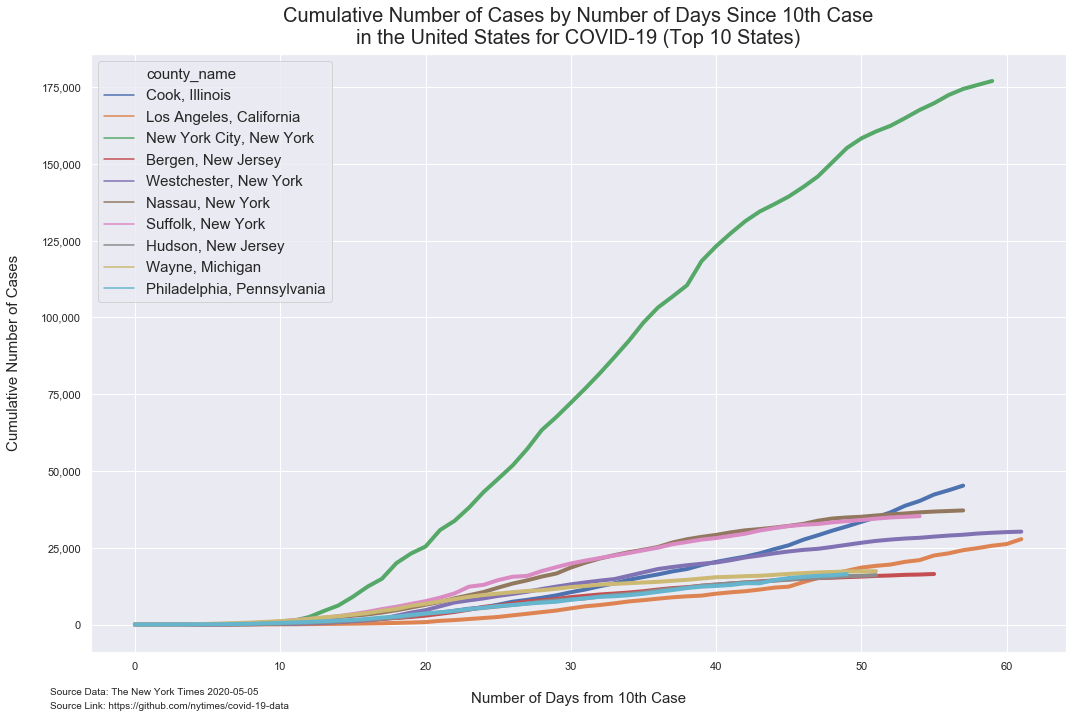

In [88]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case')

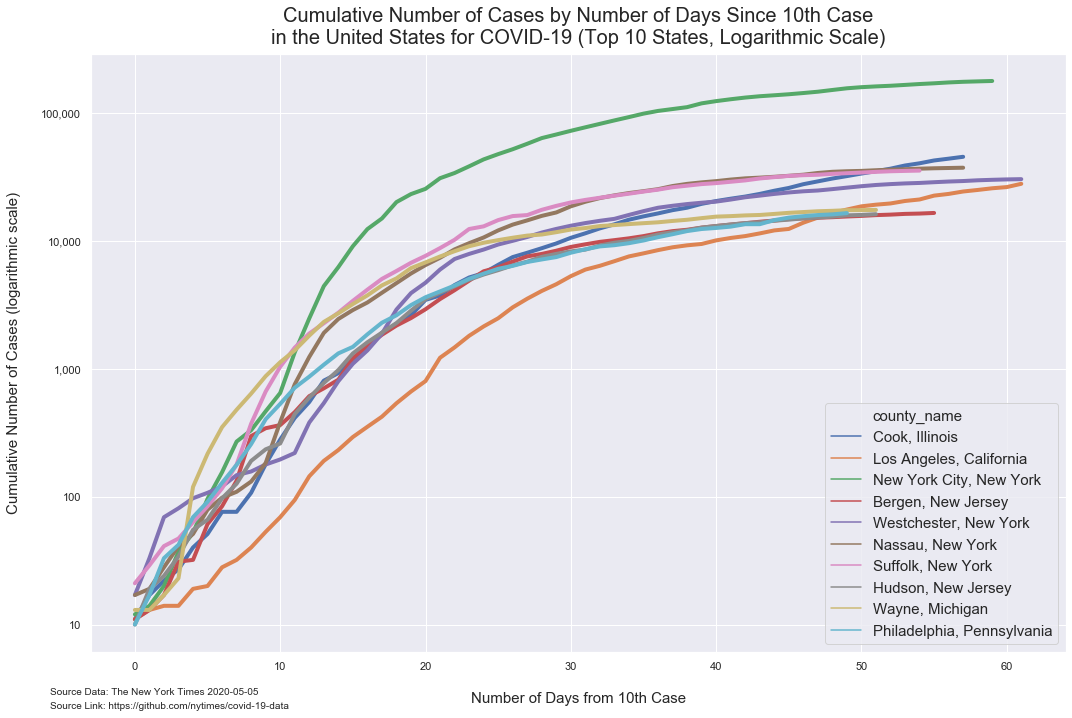

In [89]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [90]:
ten_cases_all_states = covid_19_counties_data.loc[covid_19_counties_data['cases'] >= 10]

In [91]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="county_name", keep = 'first').reset_index(drop=True)

In [92]:
ten_cases_all_states = ten_cases_all_states[['county_name', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [93]:
ten_cases_all_states

county_name ten_cases_date
0           Douglas, Nebraska     2020-02-17
1                Bexar, Texas     2020-02-24
2          Solano, California     2020-02-26
3            King, Washington     2020-03-01
4     Santa Clara, California     2020-03-03
...                       ...            ...
1990          Hansford, Texas     2020-05-05
1991           Wheeler, Texas     2020-05-05
1992           Lander, Nevada     2020-05-05
1993          Clinch, Georgia     2020-05-05
1994          Clatsop, Oregon     2020-05-05

[1995 rows x 2 columns]

In [94]:
ten_cases_all_states = covid_19_counties_data.merge(ten_cases_all_states, left_on='county_name', right_on='county_name')

In [95]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [96]:
ten_cases_all_states

date     county       state     fips  cases  deaths  \
44    2020-03-05  Snohomish  Washington  53061.0     17       0   
45    2020-03-06  Snohomish  Washington  53061.0     18       0   
46    2020-03-07  Snohomish  Washington  53061.0     26       0   
47    2020-03-08  Snohomish  Washington  53061.0     36       0   
48    2020-03-09  Snohomish  Washington  53061.0     45       0   
...          ...        ...         ...      ...    ...     ...   
90211 2020-05-01   Mariposa  California   6043.0     13       0   
90212 2020-05-02   Mariposa  California   6043.0     13       0   
90213 2020-05-03   Mariposa  California   6043.0     13       0   
90214 2020-05-04   Mariposa  California   6043.0     14       0   
90215 2020-05-05   Mariposa  California   6043.0     14       0   

                 county_name ten_cases_date  
44     Snohomish, Washington     2020-03-05  
45     Snohomish, Washington     2020-03-05  
46     Snohomish, Washington     2020-03-05  
47     Snohomish, Washington     2020-03-05  
48     Snohomish, Washington     2020-03-05  
...                      ...            ...  
90211   Mariposa, California     2020-05-01  
90212   Mariposa, California     2020-05-01  
90213   Mariposa, California     2020-05-01  
90214   Mariposa, California     2020-05-01  
90215   Mariposa, California     2020-05-01  

[61125 rows x 8 columns]

In [97]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [98]:
ten_cases_all_states

date     county       state     fips  cases  deaths  \
44    2020-03-05  Snohomish  Washington  53061.0     17       0   
45    2020-03-06  Snohomish  Washington  53061.0     18       0   
46    2020-03-07  Snohomish  Washington  53061.0     26       0   
47    2020-03-08  Snohomish  Washington  53061.0     36       0   
48    2020-03-09  Snohomish  Washington  53061.0     45       0   
...          ...        ...         ...      ...    ...     ...   
90211 2020-05-01   Mariposa  California   6043.0     13       0   
90212 2020-05-02   Mariposa  California   6043.0     13       0   
90213 2020-05-03   Mariposa  California   6043.0     13       0   
90214 2020-05-04   Mariposa  California   6043.0     14       0   
90215 2020-05-05   Mariposa  California   6043.0     14       0   

                 county_name ten_cases_date  days_from_10_cases  
44     Snohomish, Washington     2020-03-05                   0  
45     Snohomish, Washington     2020-03-05                   1  
46     Snohomish, Washington     2020-03-05                   2  
47     Snohomish, Washington     2020-03-05                   3  
48     Snohomish, Washington     2020-03-05                   4  
...                      ...            ...                 ...  
90211   Mariposa, California     2020-05-01                   0  
90212   Mariposa, California     2020-05-01                   1  
90213   Mariposa, California     2020-05-01                   2  
90214   Mariposa, California     2020-05-01                   3  
90215   Mariposa, California     2020-05-01                   4  

[61125 rows x 9 columns]

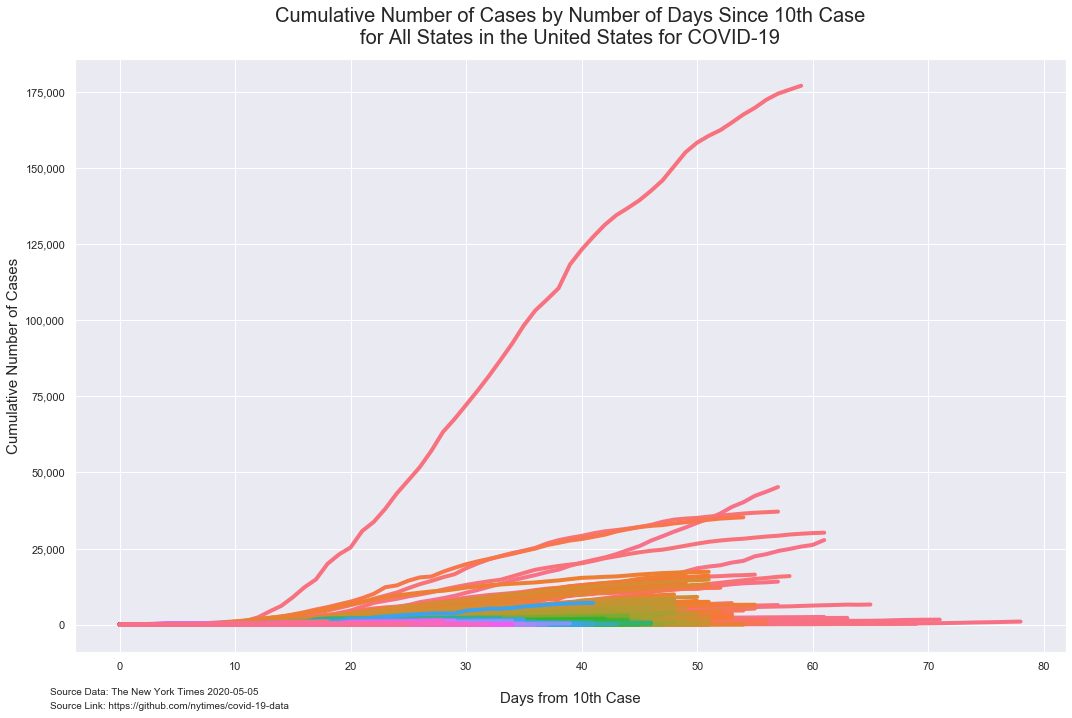

In [99]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties')

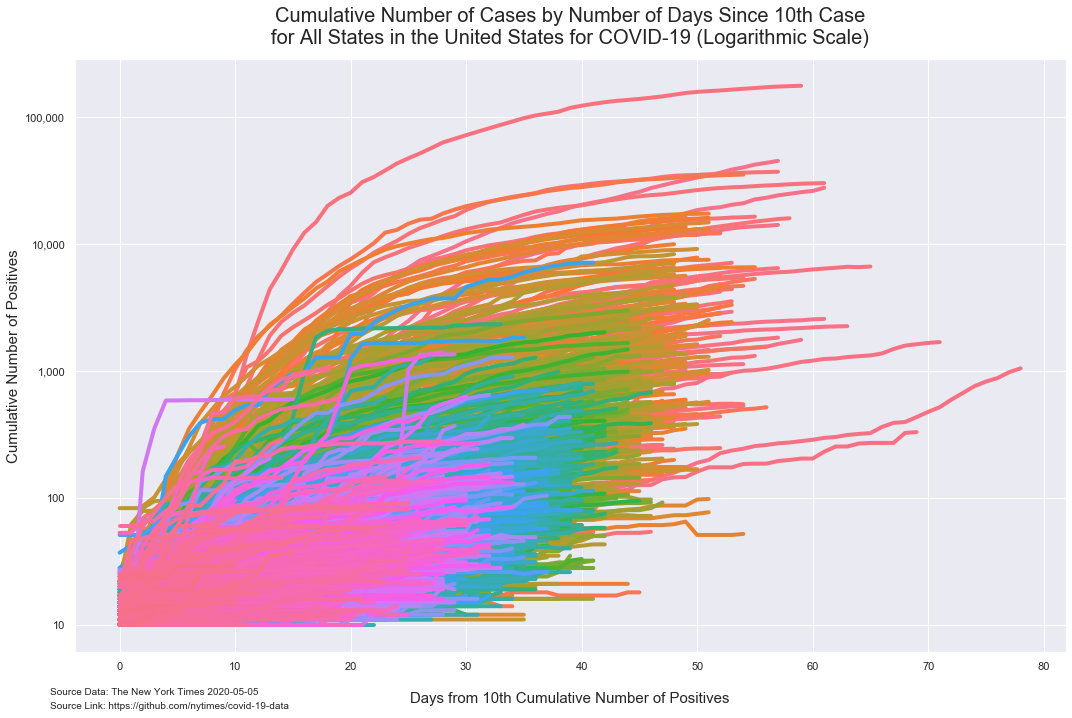

In [100]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [101]:
trajectory_plot = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [102]:
trajectory_plot[:50]

date  county         county_name  cases  daily_cases  deaths  \
277 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
278 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
279 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
280 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
281 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
282 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
283 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
284 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
285 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
286 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
287 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
288 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
289 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
290 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
291 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
292 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
293 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
294 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
295 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
296 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
297 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
298 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
299 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
300 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
301 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
302 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
303 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
304 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
305 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
306 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
307 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
308 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
309 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
310 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
311 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
312 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
313 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
314 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
315 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
316 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
317 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
318 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
319 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
320 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
321 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
322 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
323 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
324 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
325 2020-04-28  Bergen  Bergen, New Jersey  15251        147.0    1002   
326 2020-04-29  Bergen  Bergen, New Jersey  15446        195.0    1057   

    date_ten_case  days_since_ten_case  
277    2020-03-11                    0  
278    2020-03-11                    1  
279    2020-03-11                    2  
280    2020-03-11                    3  
281    2020-03-11             

In [103]:
trajectory_plot.sort_values(by='daily_cases')

date         county                 county_name   cases  \
145 2020-03-08    Los Angeles     Los Angeles, California      14   
523 2020-03-15         Hudson          Hudson, New Jersey      10   
52  2020-03-16           Cook              Cook, Illinois      76   
682 2020-04-29   Philadelphia  Philadelphia, Pennsylvania   13445   
581 2020-03-16          Wayne             Wayne, Michigan      13   
..         ...            ...                         ...     ...   
244 2020-04-10  New York City     New York City, New York   92384   
231 2020-03-28  New York City     New York City, New York   30766   
245 2020-04-11  New York City     New York City, New York   98308   
238 2020-04-04  New York City     New York City, New York   63307   
249 2020-04-15  New York City     New York City, New York  118302   

     daily_cases  deaths date_ten_case  days_since_ten_case  
145          0.0       0    2020-03-05                    3  
523          0.0       0    2020-03-15                    0  
52           0.0       0    2020-03-09                    7  
682          0.0     516    2020-03-17                   43  
581          0.0       0    2020-03-15                    1  
..           ...     ...           ...                  ...  
244       5356.0    5663    2020-03-07                   34  
231       5367.0     672    2020-03-07                   21  
245       5924.0    6202    2020-03-07                   35  
238       6147.0    2254    2020-03-07                   28  
249       7837.0    8215    2020-03-07                   39  

[565 rows x 8 columns]

In [104]:
trajectory_plot['daily_cases'].loc[trajectory_plot.daily_cases == 0] = 1

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


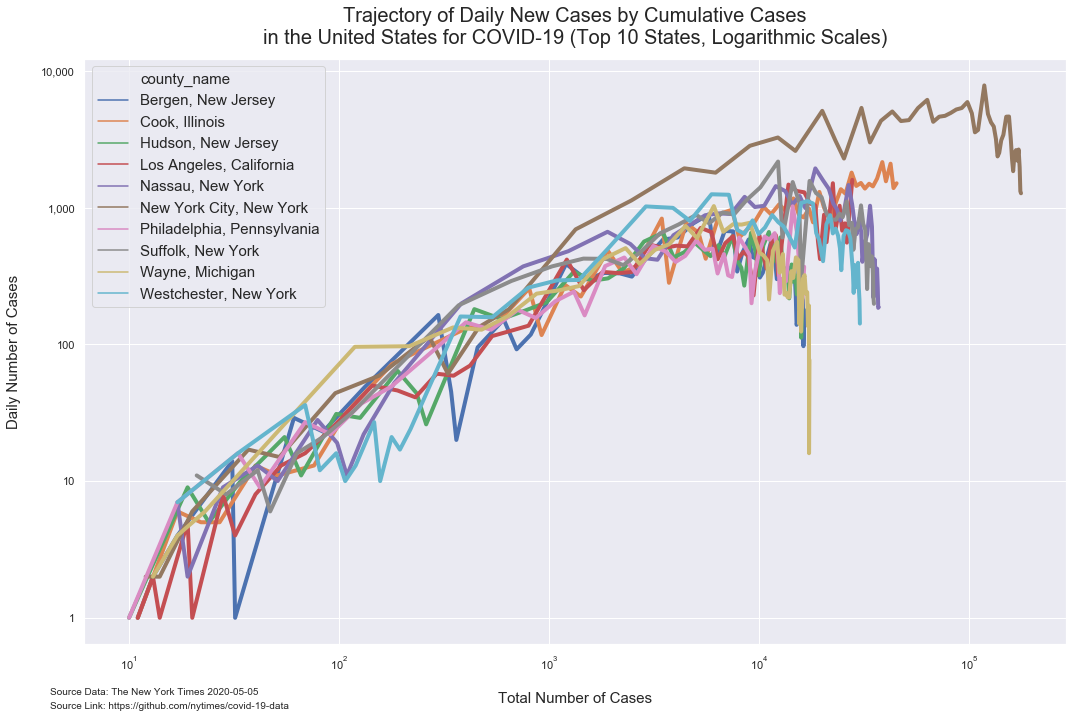

In [105]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="county_name",
             data=trajectory_plot, linewidth=4, ci=False)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
#plt.savefig('figures/county-trajectory-daily-plot')

## Weekly

In [106]:
trajectory_plot_weekly = trajectory_plot[['county_name', 'date', 'cases', 'daily_cases']]

In [107]:
trajectory_plot_weekly.head()

county_name       date  cases  daily_cases
277  Bergen, New Jersey 2020-03-11     11          1.0
278  Bergen, New Jersey 2020-03-12     13          2.0
279  Bergen, New Jersey 2020-03-13     17          4.0
280  Bergen, New Jersey 2020-03-14     31         14.0
281  Bergen, New Jersey 2020-03-15     32          1.0

In [108]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [109]:
trajectory_plot_weekly

cases  daily_cases
county_name           date                          
Bergen, New Jersey    2020-03-15     32     4.400000
                      2020-03-22    457    60.714286
                      2020-03-29   2169   244.571429
                      2020-04-05   6187   574.000000
                      2020-04-12   9784   513.857143
...                                 ...          ...
Westchester, New York 2020-04-12  19313   798.714286
                      2020-04-19  23803   641.428571
                      2020-04-26  27664   551.571429
                      2020-05-03  29884   317.142857
                      2020-05-10  30239   177.500000

[92 rows x 2 columns]

In [110]:
trajectory_plot_weekly.reset_index(inplace=True)

In [111]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [112]:
trajectory_plot_weekly

county_name       date  cases  daily_cases_weekly_average
0      Bergen, New Jersey 2020-03-15     32                    4.400000
1      Bergen, New Jersey 2020-03-22    457                   60.714286
2      Bergen, New Jersey 2020-03-29   2169                  244.571429
3      Bergen, New Jersey 2020-04-05   6187                  574.000000
4      Bergen, New Jersey 2020-04-12   9784                  513.857143
..                    ...        ...    ...                         ...
87  Westchester, New York 2020-04-12  19313                  798.714286
88  Westchester, New York 2020-04-19  23803                  641.428571
89  Westchester, New York 2020-04-26  27664                  551.571429
90  Westchester, New York 2020-05-03  29884                  317.142857
91  Westchester, New York 2020-05-10  30239                  177.500000

[92 rows x 4 columns]

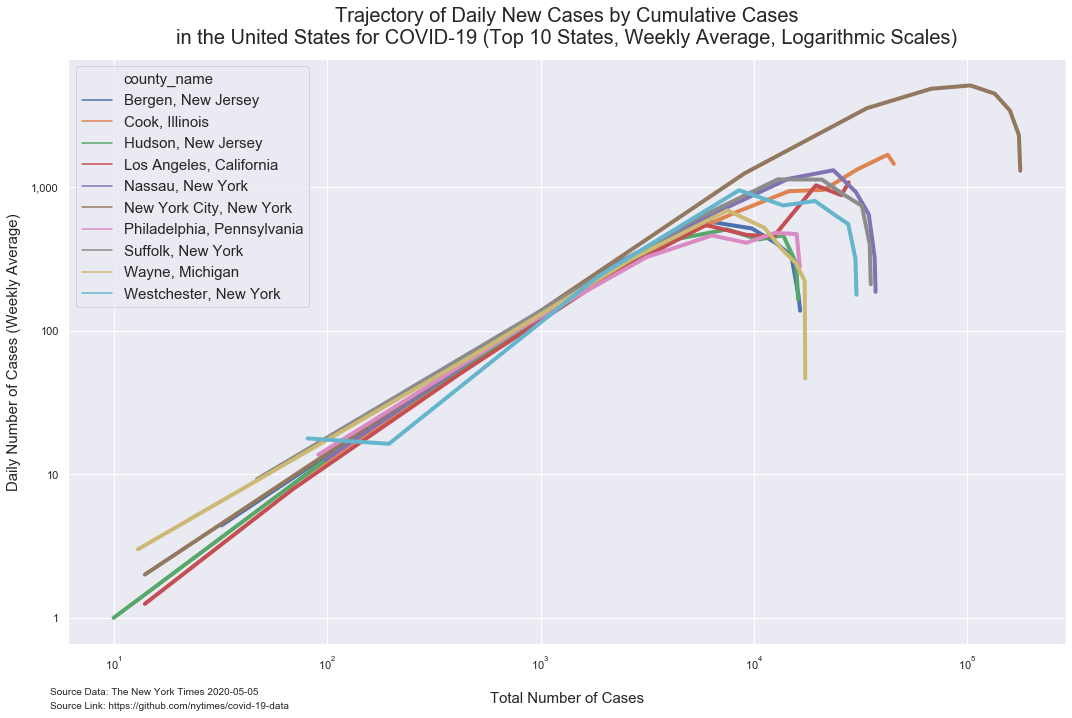

In [113]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-weekly-plot')

In [114]:
trajectory_plot_weekly_scatter = trajectory_plot_weekly.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="county_name", 
                                                                                        keep = 'first').reset_index(drop=True)

In [115]:
trajectory_plot_weekly_scatter

county_name       date   cases  daily_cases_weekly_average
0     New York City, New York 2020-05-10  176935                      1297.0
1              Cook, Illinois 2020-05-10   45223                      1449.5
2            Nassau, New York 2020-05-10   37152                       186.0
3           Suffolk, New York 2020-05-10   35275                       210.0
4       Westchester, New York 2020-05-10   30239                       177.5
5     Los Angeles, California 2020-05-10   27815                      1076.5
6             Wayne, Michigan 2020-05-10   17391                        46.5
7          Bergen, New Jersey 2020-05-10   16460                       137.5
8  Philadelphia, Pennsylvania 2020-05-10   16410                       278.0
9          Hudson, New Jersey 2020-05-10   16099                       165.0

In [116]:
len(trajectory_plot_weekly_scatter)

10

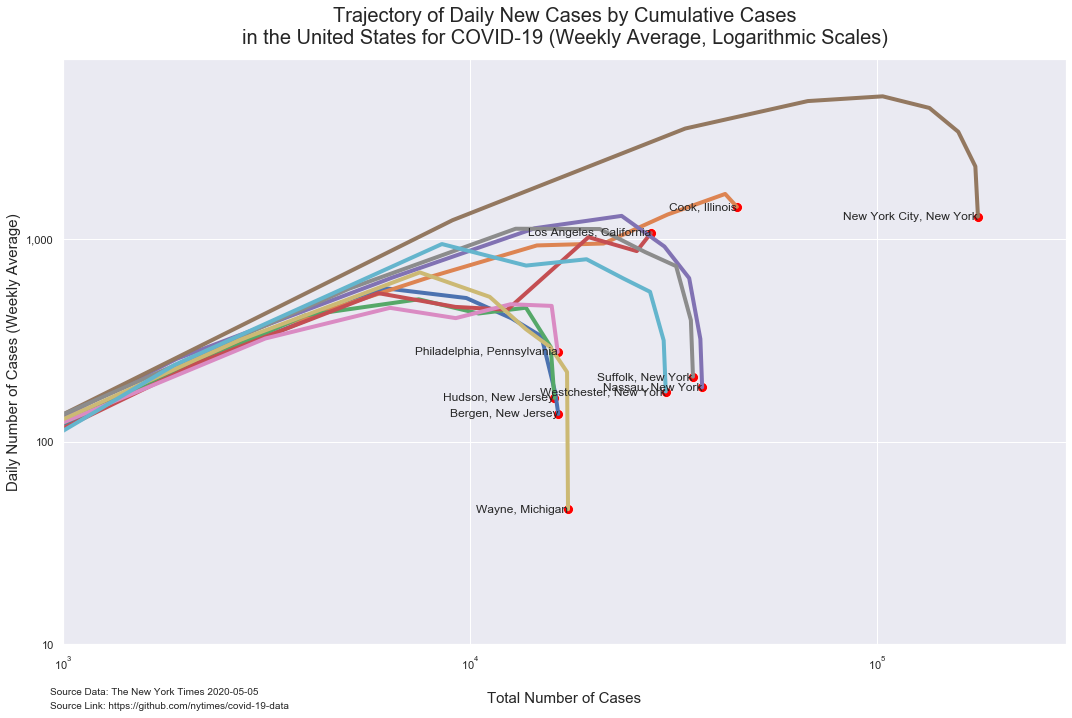

In [117]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

sns.scatterplot(x="cases", y="daily_cases_weekly_average", 
             data=trajectory_plot_weekly_scatter, s=100, ax=ax1, color='red')


x = trajectory_plot_weekly_scatter.daily_cases_weekly_average
z = trajectory_plot_weekly_scatter.cases
n = trajectory_plot_weekly_scatter.county_name
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
plt.xlim(1000)
plt.ylim(10)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot-labels')

# Trajectory for All Counties

In [118]:
trajectory_all_counties = covid_19_counties_data.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [119]:
trajectory_all_counties

date     county           state     fips  cases  deaths  \
5000   2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873   2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877   2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997   2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209   2020-03-23  Abbeville  South Carolina  45001.0      1       0   
...           ...        ...             ...      ...    ...     ...   
106478 2020-05-01     Zavala           Texas  48507.0      1       0   
109348 2020-05-02     Zavala           Texas  48507.0      1       0   
112223 2020-05-03     Zavala           Texas  48507.0      1       0   
115108 2020-05-04     Zavala           Texas  48507.0      1       0   
117994 2020-05-05     Zavala           Texas  48507.0      1       0   

                      county_name  
5000    Abbeville, South Carolina  
5873    Abbeville, South Carolina  
6877    Abbeville, South Carolina  
7997    Abbeville, South Carolina  
9209    Abbeville, South Carolina  
...                           ...  
106478              Zavala, Texas  
109348              Zavala, Texas  
112223              Zavala, Texas  
115108              Zavala, Texas  
117994              Zavala, Texas  

[117084 rows x 7 columns]

In [120]:
trajectory_all_counties['daily_cases'] = trajectory_all_counties['cases'].diff()

In [121]:
trajectory_all_counties[150:200]

date county  state     fips  cases  deaths  county_name  \
8530   2020-03-23    Ada  Idaho  16001.0     15       0   Ada, Idaho   
9795   2020-03-24    Ada  Idaho  16001.0     22       0   Ada, Idaho   
11183  2020-03-25    Ada  Idaho  16001.0     37       0   Ada, Idaho   
12743  2020-03-26    Ada  Idaho  16001.0     54       0   Ada, Idaho   
14427  2020-03-27    Ada  Idaho  16001.0     76       0   Ada, Idaho   
16229  2020-03-28    Ada  Idaho  16001.0     88       1   Ada, Idaho   
18138  2020-03-29    Ada  Idaho  16001.0    113       2   Ada, Idaho   
20148  2020-03-30    Ada  Idaho  16001.0    151       3   Ada, Idaho   
22251  2020-03-31    Ada  Idaho  16001.0    195       3   Ada, Idaho   
24430  2020-04-01    Ada  Idaho  16001.0    226       3   Ada, Idaho   
26670  2020-04-02    Ada  Idaho  16001.0    307       3   Ada, Idaho   
28972  2020-04-03    Ada  Idaho  16001.0    351       3   Ada, Idaho   
31334  2020-04-04    Ada  Idaho  16001.0    385       3   Ada, Idaho   
33741  2020-04-05    Ada  Idaho  16001.0    402       3   Ada, Idaho   
36195  2020-04-06    Ada  Idaho  16001.0    419       3   Ada, Idaho   
38687  2020-04-07    Ada  Idaho  16001.0    438       3   Ada, Idaho   
41229  2020-04-08    Ada  Idaho  16001.0    447       5   Ada, Idaho   
43796  2020-04-09    Ada  Idaho  16001.0    494       6   Ada, Idaho   
46394  2020-04-10    Ada  Idaho  16001.0    513       6   Ada, Idaho   
49024  2020-04-11    Ada  Idaho  16001.0    517       6   Ada, Idaho   
51685  2020-04-12    Ada  Idaho  16001.0    517       6   Ada, Idaho   
54366  2020-04-13    Ada  Idaho  16001.0    529       9   Ada, Idaho   
57059  2020-04-14    Ada  Idaho  16001.0    530       9   Ada, Idaho   
59766  2020-04-15    Ada  Idaho  16001.0    540       9   Ada, Idaho   
62490  2020-04-16    Ada  Idaho  16001.0    548       9   Ada, Idaho   
65224  2020-04-17    Ada  Idaho  16001.0    567       9   Ada, Idaho   
67974  2020-04-18    Ada  Idaho  16001.0    570      10   Ada, Idaho   
70736  2020-04-19    Ada  Idaho  16001.0    570      10   Ada, Idaho   
73506  2020-04-20    Ada  Idaho  16001.0    587      12   Ada, Idaho   
76283  2020-04-21    Ada  Idaho  16001.0    589      12   Ada, Idaho   
79066  2020-04-22    Ada  Idaho  16001.0    597      14   Ada, Idaho   
81862  2020-04-23    Ada  Idaho  16001.0    601      14   Ada, Idaho   
84663  2020-04-24    Ada  Idaho  16001.0    610      14   Ada, Idaho   
87474  2020-04-25    Ada  Idaho  16001.0    615      15   Ada, Idaho   
90292  2020-04-26    Ada  Idaho  16001.0    615      15   Ada, Idaho   
93112  2020-04-27    Ada  Idaho  16001.0    621      15   Ada, Idaho   
95943  2020-04-28    Ada  Idaho  16001.0    623      16   Ada, Idaho   
98784  2020-04-29    Ada  Idaho  16001.0    629      16   Ada, Idaho   
101632 2020-04-30    Ada  Idaho  16001.0    638      16   Ada, Idaho   
104486 2020-05-01    Ada  Idaho  16001.0    647      16   Ada, Idaho   
107352 2020-05-02    Ada  Idaho  16001.0    664      17   Ada, Idaho   
110223 2020-05-03    Ada  Idaho  16001.0    664      17   Ada, Idaho   
113099 2020-05-04    Ada  Idaho  16001.0    669      17   Ada, Idaho   
115984 2020-05-05    Ada  Idaho  16001.0    670      19   Ada, Idaho   
3388   2020-03-17  Adair   Iowa  19001.0      1       0  Adair, Iowa   
3962   2020-03-18  Adair   Iowa  19001.0      1       0  Adair, Iowa   
4641   2020-03-19  Adair   Iowa  19001.0      1       0  Adair, Iowa   
5452   2020-03-20  Adair   Iowa  19001.0      1       0  Adair, Iowa   
6393   2020-03-21  Adair   Iowa  19001.0      1       0  Adair, Iowa   
7453   2020-03-22  Adair   Iowa  19001.0      1       0  Adair, Iowa   

        daily_cases  
8530            2.0  
9795            7.0  
11183          15.0  
12743          17.0  
14427          22.0  
16229          12.0  
18138          25.0  
20148          38.0  
22251          44.0  
24430          31.0  
26670          81.0  
28972          44.0  
31334          34.0  
33741          17.0  
36195     

In [122]:
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases < 0] = trajectory_all_counties.cases
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases.isnull()] = trajectory_all_counties.cases

In [123]:
trajectory_all_counties[:50]

date     county           state     fips  cases  deaths  \
5000   2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873   2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877   2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997   2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209   2020-03-23  Abbeville  South Carolina  45001.0      1       0   
10539  2020-03-24  Abbeville  South Carolina  45001.0      1       0   
12015  2020-03-25  Abbeville  South Carolina  45001.0      3       0   
13647  2020-03-26  Abbeville  South Carolina  45001.0      4       0   
15404  2020-03-27  Abbeville  South Carolina  45001.0      4       0   
17268  2020-03-28  Abbeville  South Carolina  45001.0      4       0   
19222  2020-03-29  Abbeville  South Carolina  45001.0      4       0   
21283  2020-03-30  Abbeville  South Carolina  45001.0      3       0   
23435  2020-03-31  Abbeville  South Carolina  45001.0      4       0   
25642  2020-04-01  Abbeville  South Carolina  45001.0      4       0   
27915  2020-04-02  Abbeville  South Carolina  45001.0      6       0   
30250  2020-04-03  Abbeville  South Carolina  45001.0      6       0   
32642  2020-04-04  Abbeville  South Carolina  45001.0      6       0   
35080  2020-04-05  Abbeville  South Carolina  45001.0      6       0   
37558  2020-04-06  Abbeville  South Carolina  45001.0      6       0   
40078  2020-04-07  Abbeville  South Carolina  45001.0      5       0   
42634  2020-04-08  Abbeville  South Carolina  45001.0      6       0   
45214  2020-04-09  Abbeville  South Carolina  45001.0      7       0   
47830  2020-04-10  Abbeville  South Carolina  45001.0      7       0   
50485  2020-04-11  Abbeville  South Carolina  45001.0      9       0   
53158  2020-04-12  Abbeville  South Carolina  45001.0      9       0   
55845  2020-04-13  Abbeville  South Carolina  45001.0      9       0   
58548  2020-04-14  Abbeville  South Carolina  45001.0      9       0   
61266  2020-04-15  Abbeville  South Carolina  45001.0     10       0   
63994  2020-04-16  Abbeville  South Carolina  45001.0     10       0   
66742  2020-04-17  Abbeville  South Carolina  45001.0     10       0   
69500  2020-04-18  Abbeville  South Carolina  45001.0     15       0   
72268  2020-04-19  Abbeville  South Carolina  45001.0     17       0   
75045  2020-04-20  Abbeville  South Carolina  45001.0     17       0   
77827  2020-04-21  Abbeville  South Carolina  45001.0     18       0   
80618  2020-04-22  Abbeville  South Carolina  45001.0     22       0   
83419  2020-04-23  Abbeville  South Carolina  45001.0     23       0   
86224  2020-04-24  Abbeville  South Carolina  45001.0     24       0   
89040  2020-04-25  Abbeville  South Carolina  45001.0     24       0   
91857  2020-04-26  Abbeville  South Carolina  45001.0     27       0   
94684  2020-04-27  Abbeville  South Carolina  45001.0     29       0   
97521  2020-04-28  Abbeville  South Carolina  45001.0     29       0   
100368 2020-04-29  Abbeville  South Carolina  45001.0     29       0   
103220 2020-04-30  Abbeville  South Carolina  45001.0     31       0   
106083 2020-05-01  Abbeville  South Carolina  45001.0     31       0   
108951 2020-05-02  Abbeville  South Carolina  45001.0     31       0   
111826 2020-05-03  Abbeville  South Carolina  45001.0     33       0   
114710 2020-05-04  Abbeville  South Carolina  45001.0     33       0   
117593 2020-05-05  Abbeville  South Carolina  45001.0     33       0   
7518   2020-03-22     Acadia       Louisiana  22001.0      1       0   
8681   2020-03-23     Acadia       Louisiana  22001.0      1       0   

                      county_name  daily_cases  
5000    Abbeville, South Carolina          1.0  
5873    Abbeville, South Carolina          0.0  
6877    Abbeville, South Carolina          0.0  
7997    Abbeville, South Carolina          0.0  
9209    Abbeville, South Carolina          0.0  
10539   Abbeville, South Carolina          0.0

In [124]:
trajectory_all_counties = trajectory_all_counties.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_counties.reset_index(inplace=True)
trajectory_all_counties.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [125]:
trajectory_all_counties.head()

county_name       date  cases  daily_cases_week_avg
0  Abbeville, South Carolina 2020-03-22    1.0              0.250000
1  Abbeville, South Carolina 2020-03-29    4.0              0.428571
2  Abbeville, South Carolina 2020-04-05    6.0              0.857143
3  Abbeville, South Carolina 2020-04-12    9.0              1.285714
4  Abbeville, South Carolina 2020-04-19   17.0              1.142857

In [126]:
temp_fill_zeros = trajectory_all_counties.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['cases'].loc[temp_fill_zeros.cases < 1] = 1
temp_fill_zeros['daily_cases_week_avg'].loc[temp_fill_zeros.daily_cases_week_avg < 1] = 1

temp_fill_zeros

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
20055              Zapata, Texas 2020-05-10    7.0              1.000000
20056              Zavala, Texas 2020-04-19    1.0              1.000000
20057              Zavala, Texas 2020-04-26    1.0              1.000000
20058              Zavala, Texas 2020-05-03    1.0              1.000000
20059              Zavala, Texas 2020-05-10    1.0              1.000000

[20060 rows x 4 columns]

In [127]:
temp_fill_zeros.loc[temp_fill_zeros.cases.isnull() == True]

county_name       date  cases  daily_cases_week_avg
1192          Benzie, Michigan 2020-04-12    NaN                   NaN
2786           Cedar, Nebraska 2020-04-26    NaN                   NaN
4740         Day, South Dakota 2020-04-26    NaN                   NaN
4857        Decatur, Tennessee 2020-04-05    NaN                   NaN
8680   Jackson, North Carolina 2020-04-12    NaN                   NaN
11389         Marion, Missouri 2020-04-12    NaN                   NaN
12014     Mercer, North Dakota 2020-04-12    NaN                   NaN
12015     Mercer, North Dakota 2020-04-19    NaN                   NaN
12016     Mercer, North Dakota 2020-04-26    NaN                   NaN
12017     Mercer, North Dakota 2020-05-03    NaN                   NaN
15282          Rhea, Tennessee 2020-04-12    NaN                   NaN
19009        Washita, Oklahoma 2020-04-12    NaN                   NaN
19010        Washita, Oklahoma 2020-04-19    NaN                   NaN
19961            Yoakum, Texas 2020-04-12    NaN                   NaN

In [128]:
temp_fill_zeros.dropna()

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
20055              Zapata, Texas 2020-05-10    7.0              1.000000
20056              Zavala, Texas 2020-04-19    1.0              1.000000
20057              Zavala, Texas 2020-04-26    1.0              1.000000
20058              Zavala, Texas 2020-05-03    1.0              1.000000
20059              Zavala, Texas 2020-05-10    1.0              1.000000

[20046 rows x 4 columns]

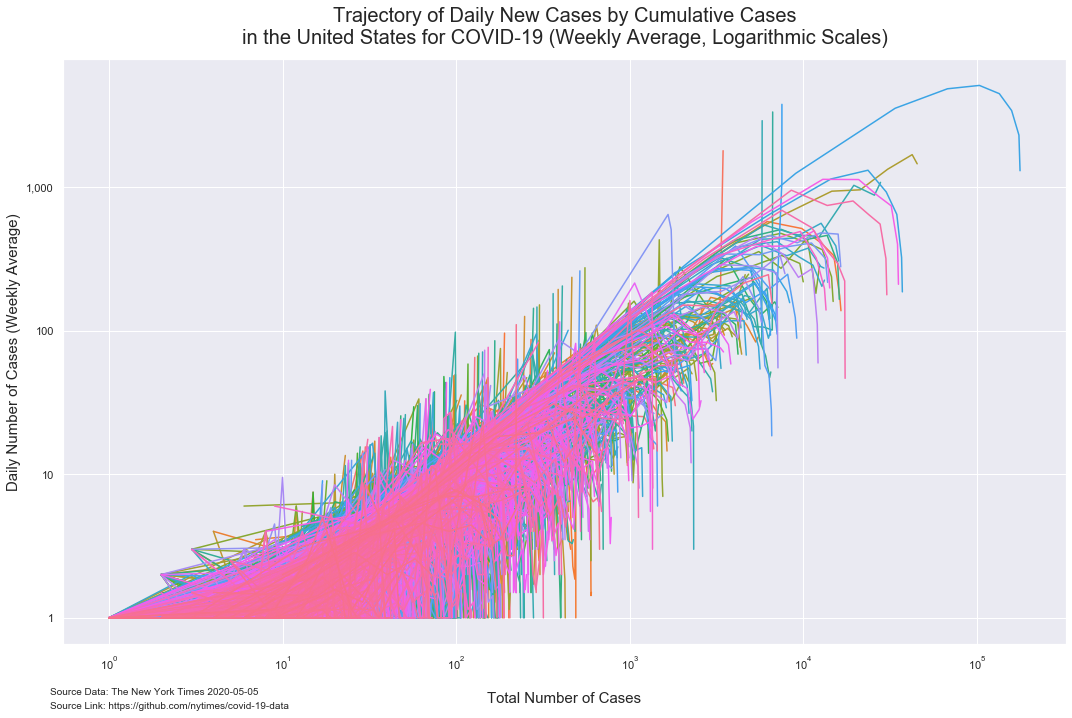

In [129]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="county_name",
             data=temp_fill_zeros, ci=False)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot')

# Timeseries for USA

In [130]:
g = covid_19_counties_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [131]:
g.index.dtype

dtype('<M8[ns]')

In [132]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [133]:
g.tail()

date    cases
date                          
2020-05-01 2020-05-01  1095113
2020-05-02 2020-05-02  1124231
2020-05-03 2020-05-03  1149155
2020-05-04 2020-05-04  1171203
2020-05-05 2020-05-05  1194892

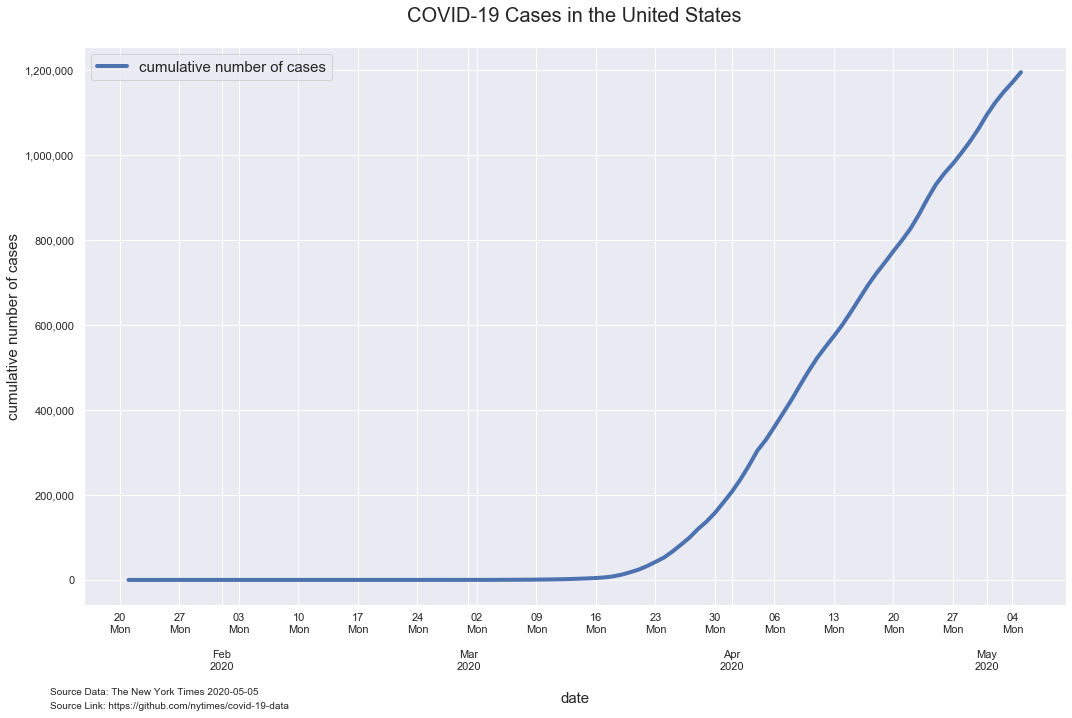

In [134]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-linear')

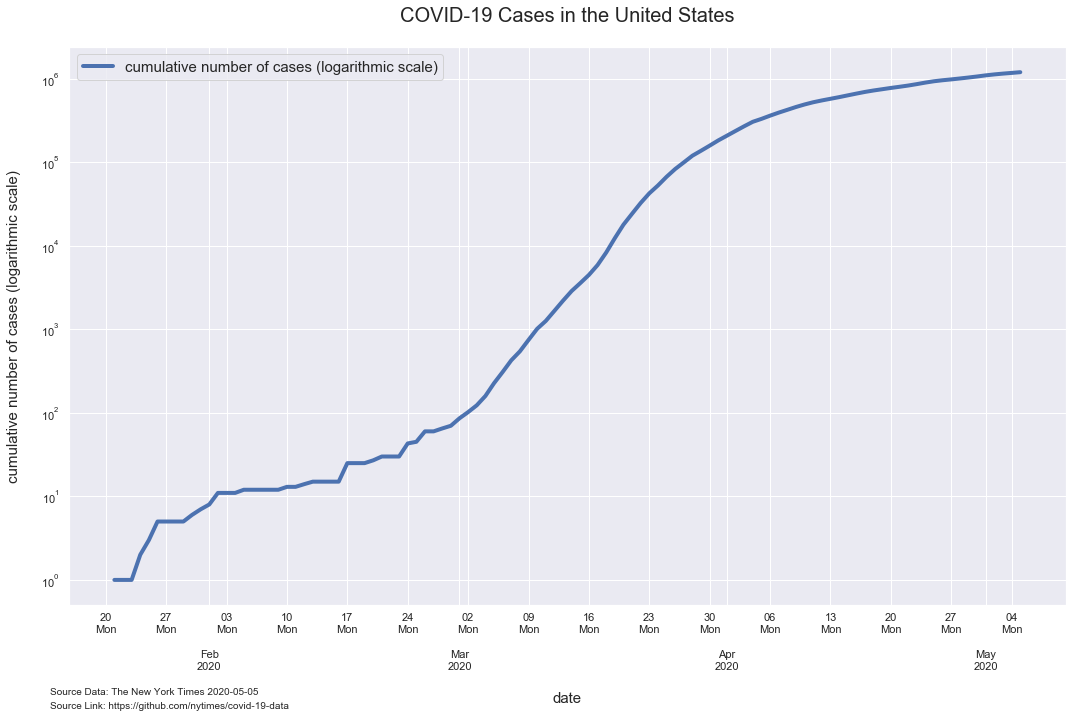

In [135]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/counties-log')

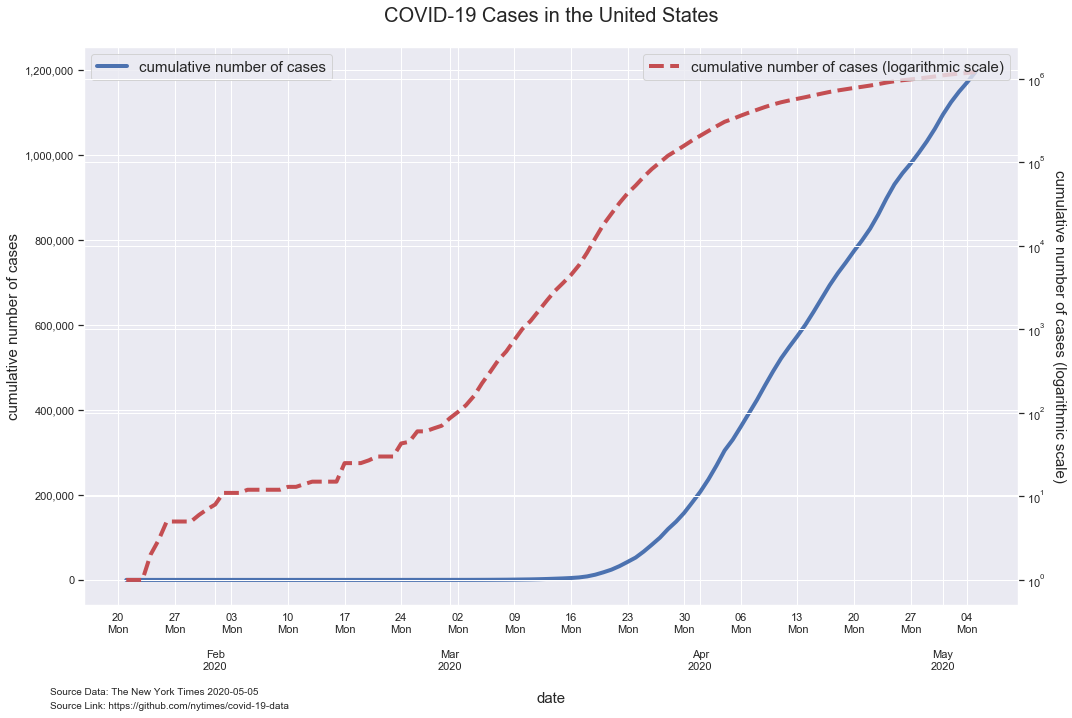

In [136]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-timeseries-overlay')

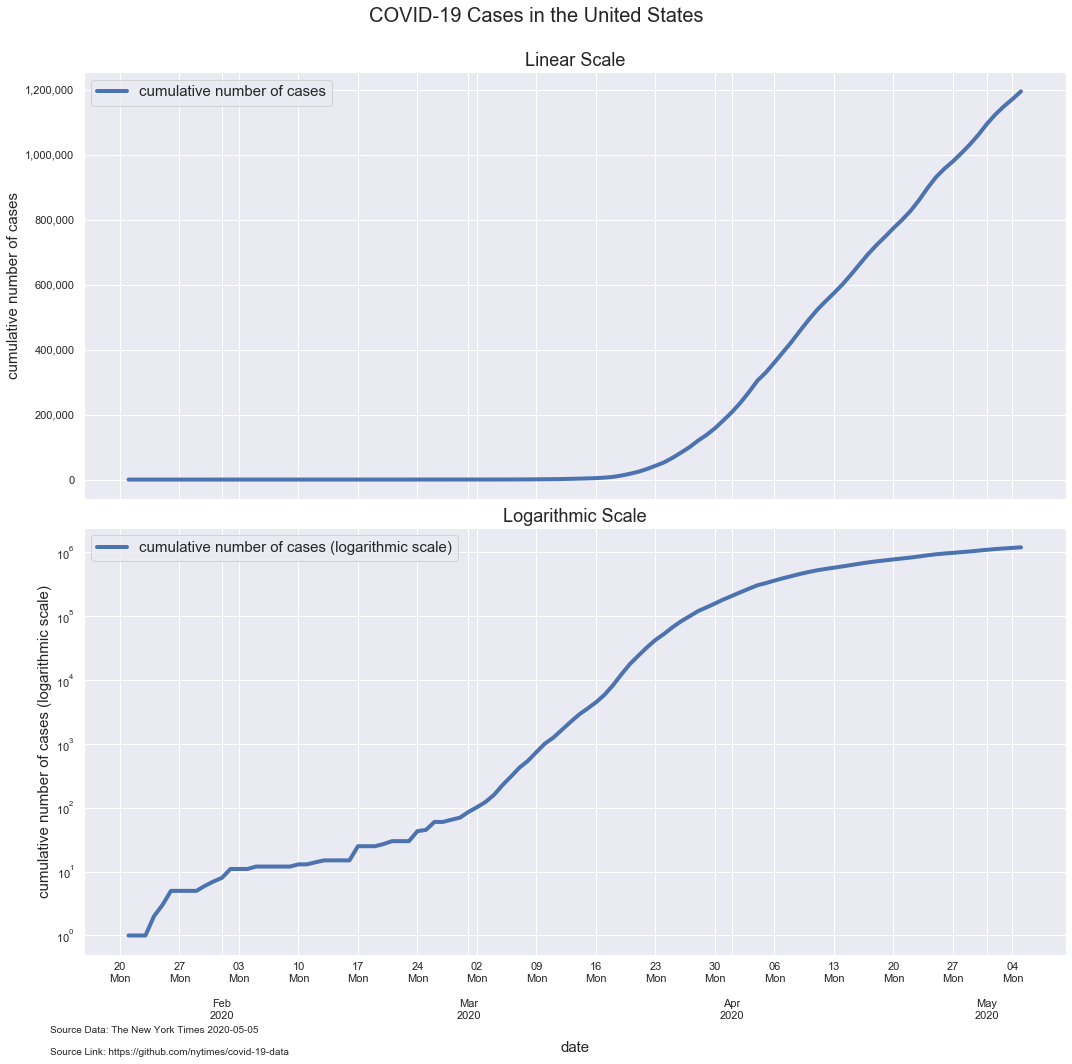

In [137]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/counties-timeseries-2-subplots')

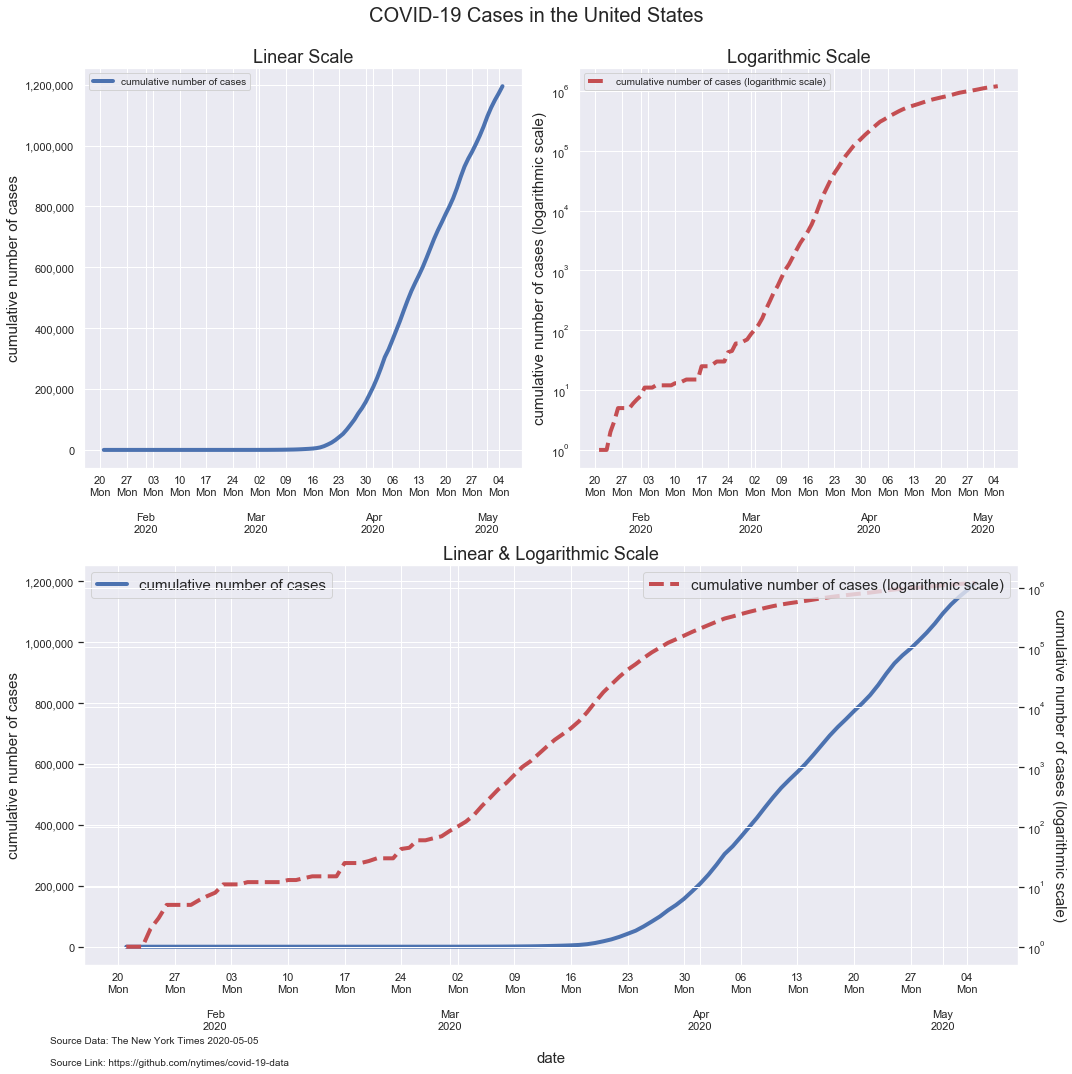

In [138]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-3-subplots')

# Country Trajectory Plot

In [139]:
g['daily_cases'] = g['cases'].diff()

In [140]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [141]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [142]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     86         16.0
2020-03-02 2020-03-02    102         16.0
2020-03-03 2020-03-03    123         21.0
2020-03-04 2020-03-04    159         36.0
2020-03-05 2020-03-05    226         67.0
2020-03-06 2020-03-06    308         82.0
2020-03-07 2020-03-07    425        117.0
2020-03-08 2020-03-08    544        119.0
2020-03-09 2020-03-09    745        201.0
2020-03-10 2020-03-10   1013        268.0

In [143]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [144]:
g_weekly

cases   daily_cases
date                             
2020-01-26        5      0.833333
2020-02-02       11      0.857143
2020-02-09       12      0.142857
2020-02-16       15      0.428571
2020-02-23       30      2.142857
2020-03-01       86      8.000000
2020-03-08      544     65.428571
2020-03-15     3570    432.285714
2020-03-22    32503   4133.285714
2020-03-29   137191  14955.428571
2020-04-05   329961  27538.571429
2020-04-12   548541  31225.714286
2020-04-19   747262  28388.714286
2020-04-26   957125  29980.428571
2020-05-03  1149155  27432.857143
2020-05-10  1194892  22868.500000

In [145]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [146]:
g_weekly

date    cases   daily_cases
0  2020-01-26        5      0.833333
1  2020-02-02       11      0.857143
2  2020-02-09       12      0.142857
3  2020-02-16       15      0.428571
4  2020-02-23       30      2.142857
5  2020-03-01       86      8.000000
6  2020-03-08      544     65.428571
7  2020-03-15     3570    432.285714
8  2020-03-22    32503   4133.285714
9  2020-03-29   137191  14955.428571
10 2020-04-05   329961  27538.571429
11 2020-04-12   548541  31225.714286
12 2020-04-19   747262  28388.714286
13 2020-04-26   957125  29980.428571
14 2020-05-03  1149155  27432.857143
15 2020-05-10  1194892  22868.500000

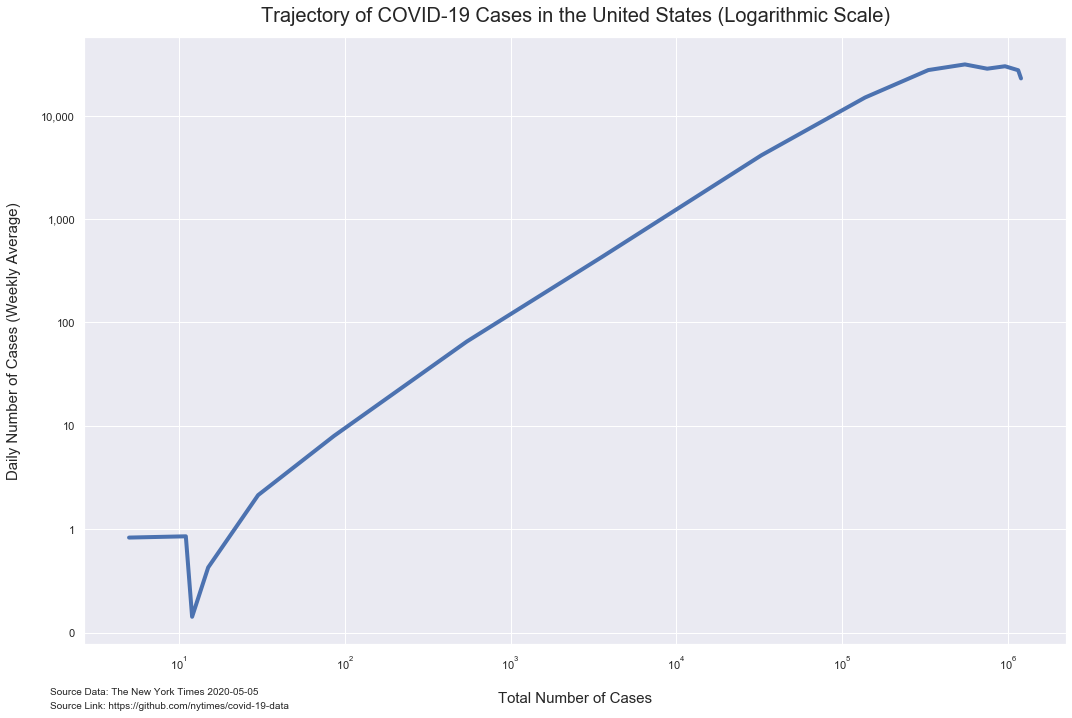

In [147]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/usa-counties-trajectory-weekly-plot')

# Bar Chart

In [148]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0      2020-01-21   Snohomish  Washington  53061.0      1       0   
1      2020-01-22   Snohomish  Washington  53061.0      1       0   
2      2020-01-23   Snohomish  Washington  53061.0      1       0   
3      2020-01-24        Cook    Illinois  17031.0      1       0   
4      2020-01-24   Snohomish  Washington  53061.0      1       0   
...           ...         ...         ...      ...    ...     ...   
118338 2020-05-05    Sublette     Wyoming  56035.0      1       0   
118339 2020-05-05  Sweetwater     Wyoming  56037.0     11       0   
118340 2020-05-05       Teton     Wyoming  56039.0     67       1   
118341 2020-05-05       Uinta     Wyoming  56041.0      6       0   
118342 2020-05-05    Washakie     Wyoming  56043.0      4       0   

                  county_name  
0       Snohomish, Washington  
1       Snohomish, Washington  
2       Snohomish, Washington  
3              Cook, Illinois  
4       Snohomish, Washington  
...                       ...  
118338      Sublette, Wyoming  
118339    Sweetwater, Wyoming  
118340         Teton, Wyoming  
118341         Uinta, Wyoming  
118342      Washakie, Wyoming  

[117084 rows x 7 columns]

In [149]:
# dropping ALL duplicate values 
county_current_cases = covid_19_counties_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="county_name", keep = 'first')

In [150]:
county_current_cases.head()

date     county     state     fips  cases  deaths  \
118342 2020-05-05   Washakie   Wyoming  56043.0      4       0   
116404 2020-05-05  Christian  Kentucky  21047.0     91       3   
116424 2020-05-05    Hancock  Kentucky  21091.0      6       0   
116423 2020-05-05    Greenup  Kentucky  21089.0     12       0   
116422 2020-05-05      Green  Kentucky  21087.0      1       0   

                county_name  
118342    Washakie, Wyoming  
116404  Christian, Kentucky  
116424    Hancock, Kentucky  
116423    Greenup, Kentucky  
116422      Green, Kentucky

In [151]:
county_current_cases.county_name.value_counts()

Martin, Kentucky          1
Siskiyou, California      1
Knox, Kentucky            1
Cumberland, Tennessee     1
Henry, Missouri           1
                         ..
Winnebago, Wisconsin      1
Screven, Georgia          1
Lincoln, Mississippi      1
Braxton, West Virginia    1
Roosevelt, Montana        1
Name: county_name, Length: 2881, dtype: int64

In [152]:
county_current_cases.loc[county_current_cases.county == 'New York City']

date         county     state  fips   cases  deaths  \
117161 2020-05-05  New York City  New York   NaN  176935   13336   

                    county_name  
117161  New York City, New York

In [153]:
bar = county_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar = bar[:20]

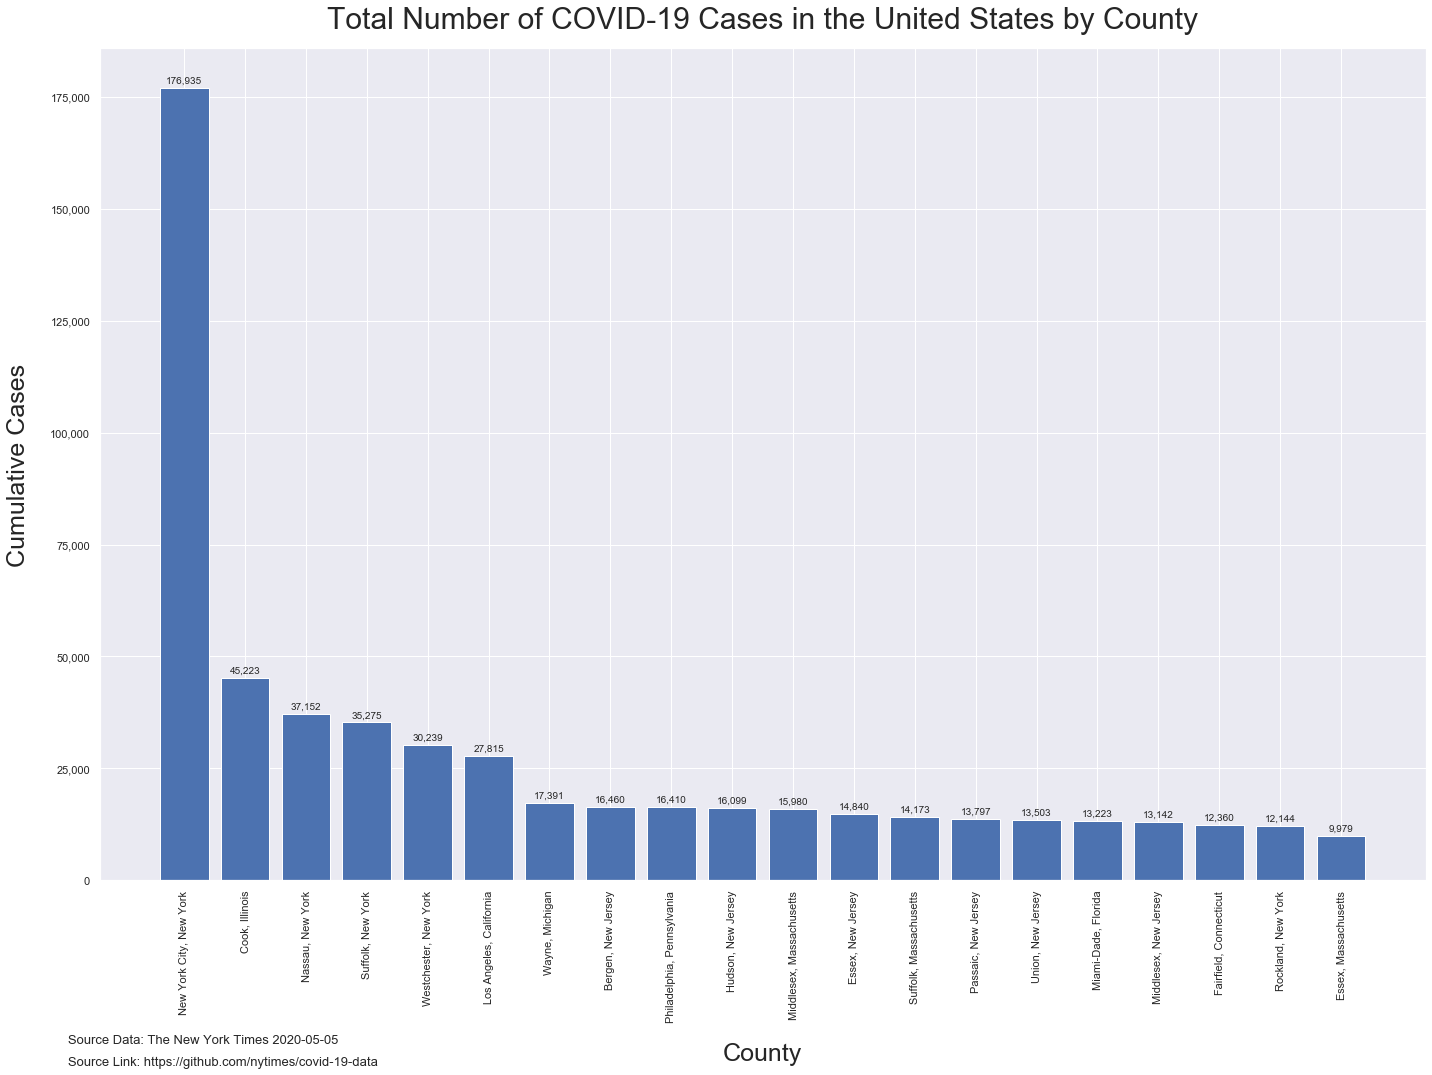

In [154]:
bar = bar.sort_values(by = 'cases', 
                    ascending=False)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("County", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-bar')

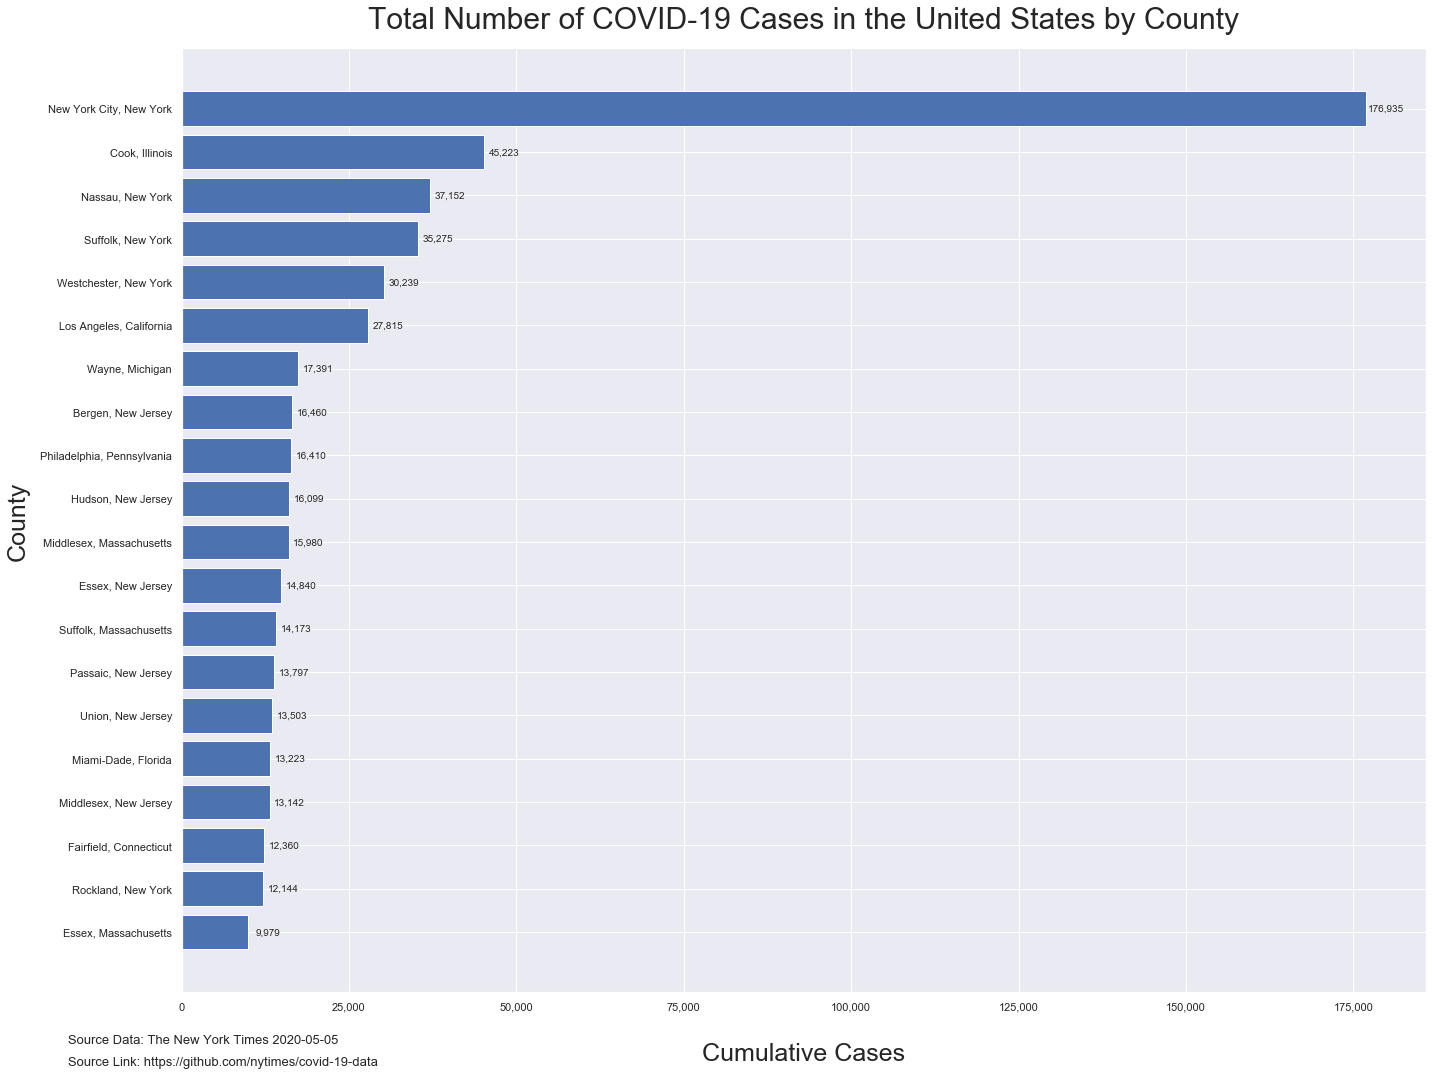

In [155]:
bar = bar.sort_values(by = 'cases', 
                    ascending=True)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("County", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-barh')

In [156]:
covid_19_counties_data.to_csv('data/us-counties-raw-data.csv', index=False)
g.to_csv('data/us-counties-grouped-day.csv')
bar.to_csv('data/us-counties-grouped-bar.csv')